In [ ]:
# Install required libraries
!pip install gymnasium matplotlib numpy

In [1]:
# Import required libraries
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import random
random.seed(1334)
import random
import pickle
import pandas as pd


/Users/hamzakhan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## I am going to be implementing the Warehouse Robot in the Notebook

## Deterministic Environment

In [2]:
class GridEnvironment(gym.Env):
    # Attribute of a Gym class that provides info about the render modes
    metadata = {'render.modes': []}

    # Initialization function
    def __init__(self):

        self.observation_space = spaces.Discrete(36)
        self.action_space = spaces.Discrete(6)
        self.max_timesteps = 200000

        self.timestep = 0
        self.state = np.zeros((6, 6))
        self.agent_pos = [0, 0]
        self.goal_pos = [5, 2]
        self.item_pos = [4, 0]
        self.obstacle1_pos = [2, 1]
        self.obstacle2_pos = [1, 4]
        self.obstacle3_pos = [3, 3]
        self.item_pickup = 0
        
        self.state[tuple(self.agent_pos)] = 5
        self.state[tuple(self.obstacle1_pos)] = 1
        self.state[tuple(self.obstacle2_pos)] = 1
        self.state[tuple(self.obstacle3_pos)] = 1
        self.state[tuple(self.item_pos)] = 2
        self.state[tuple(self.goal_pos)] = 3
        self.reward = 0
        self.goal_achieved = 0
        self.action = "null"
        self.current_reward = 0

    # Reset function
    def reset(self, **kwargs):
        self.timestep = 0
        self.state = np.zeros((6, 6))
        self.agent_pos = [0, 0]
        self.goal_pos = [5, 2]
        self.item_pos = [4, 0]
        self.obstacle1_pos = [2, 1]
        self.obstacle2_pos = [1, 4]
        self.obstacle3_pos = [3, 3]
        self.item_pickup = 0
    
        self.goal_achieved = 0
        self.state[tuple(self.agent_pos)] = 5
        self.state[tuple(self.obstacle1_pos)] = 1
        self.state[tuple(self.obstacle2_pos)] = 1
        self.state[tuple(self.obstacle3_pos)] = 1
        self.state[tuple(self.item_pos)] = 2
        self.state[tuple(self.goal_pos)] = 3
        self.action = "null"
        self.current_reward = 0
        self.reward = 0
        
        

        observation = self.state.flatten()
        info = {}

        return observation
    
    def get_num_observation_space(self):
        return self.observation_space
    
    def get_num_action_space(self):
        return self.action_space
    

    # Step function: Contains the implementation for what happens when an agent takes a step in the environment.
    def is_within_grid(self, action):
        if (self.agent_pos[0] > 5 or self.agent_pos[1] > 5) or  (self.agent_pos[0] < 0 or self.agent_pos[1] < 0):
            self.reverse_step(action)
            self.update_item_pos()
            return 0
        else:
            return 1

    def is_hitting_obstacle(self, action):
        if self.agent_pos == self.obstacle1_pos or self.agent_pos == self.obstacle2_pos or self.agent_pos == self.obstacle3_pos:
            self.reverse_step(action)
            self.reward -= 20
            return 1
        else:
            return 0

    def is_agent_on_item(self):
        if tuple(self.agent_pos) == tuple(self.item_pos):
            return 1
        else:
            return 0
        
    def check_if_item_coord_needs_update(self):
        if self.item_pickup == 1:
            self.item_pos = self.agent_pos

    def does_agent_have_item(self):
        if self.item_pickup == 1:
            return 1
        else:
            return 0

    def is_agent_on_target(self):
        if tuple(self.agent_pos) == tuple(self.goal_pos):
            return 1
        else:
            return 0
        
    def drop_item(self):
        
        if tuple(self.agent_pos) == tuple(self.goal_pos) and tuple(self.item_pos) == tuple(self.goal_pos) and self.item_pickup == 1:
            self.item_pickup = 0
            self.goal_achieved = 1
            self.reward += 20
            return 1
        else:
            self.item_pickup = 0
            return 0

    def pickup_item(self):
        if self.is_agent_on_item() and self.item_pickup == 0:
            self.item_pickup = 1
            return 1
        else:

            return 0
    
    def update_item_pos(self):
        if self.item_pickup == 1:
            self.item_pos = deepcopy(self.agent_pos)
        

    def reverse_step(self, action):
        if action == 0:  # down
            self.agent_pos[0] -= 1
        if action == 1:  # up
            self.agent_pos[0] += 1
        if action == 2:  # right
            self.agent_pos[1] -= 1
        if action == 3:  # left
            self.agent_pos[1] += 1
        
        self.update_item_pos()       

        
    def step(self, action):
        self.action = action
        self.current_reward = 0
        if action == 0:  # down
            self.agent_pos[0] += 1
            internal_check = 0
            
            if self.is_within_grid(action) == 0:
                internal_check = 1
                
                
            if self.is_hitting_obstacle(action) == 1:
                internal_check = 1
                self.current_reward = -20
            
            self.update_item_pos()
            
            if internal_check == 0:
                self.current_reward = -1
                self.reward -= 1
            
        if action == 1:  # up
            self.agent_pos[0] -= 1
            internal_check = 0
            
            if self.is_within_grid(action) == 0:
                internal_check = 1
                
                
            if self.is_hitting_obstacle(action) == 1:
                internal_check = 1
                self.current_reward = -20
            
            self.update_item_pos()
            
            if internal_check == 0:
                self.current_reward = -1
                self.reward -= 1
            
        if action == 2:  # right
                self.agent_pos[1] += 1

                internal_check = 0

                if self.is_within_grid(action) == 0:
                    internal_check = 1


                if self.is_hitting_obstacle(action) == 1:
                    internal_check = 1
                    self.current_reward = -20

                self.update_item_pos()

                if internal_check == 0:
                    self.current_reward = -1
                    self.reward -= 1
            
            
        if action == 3:  # left
            self.agent_pos[1] -= 1
            
            internal_check = 0
            
            if self.is_within_grid(action) == 0:
                internal_check = 1
                
                
            if self.is_hitting_obstacle(action) == 1:
                internal_check = 1
                self.current_reward = -20
            
            self.update_item_pos()
            
            if internal_check == 0:
                self.current_reward = -1
                self.reward -= 1
                
        if action == 4:  # pickup
            if self.is_agent_on_item() == 1 and self.does_agent_have_item() == 0:
                self.pickup_item()
                self.update_item_pos()
                
        if action == 5:  # dropoff
            self.drop_item()
            self.update_item_pos()
        

        self.state = np.zeros((6, 6))
        if self.item_pickup == 1:
            self.state[tuple(self.agent_pos)] = 6
        else:
            self.state[tuple(self.agent_pos)] = 5
            self.state[tuple(self.item_pos)] = 2
            
#         self.state[tuple(self.agent_pos)] = 5
        self.state[tuple(self.obstacle1_pos)] = 1
        self.state[tuple(self.obstacle2_pos)] = 1
        self.state[tuple(self.obstacle3_pos)] = 1
#         self.state[tuple(self.item_pos)] = 2
        self.state[tuple(self.goal_pos)] = 3
        observation = self.state.flatten()

        self.timestep += 1

        # Condition to check for termination (episode is over)
        terminated = True if ((self.timestep >= self.max_timesteps) or self.goal_achieved == 1) else False

        info = {}
        if terminated == True:
            self.current_reward = 20
            
        return self.state.flatten(), self.current_reward, terminated

    # Render function: Visualizes the environment
    def render(self):
        plt.title('Grid Environment')
        plt.imshow(self.state)
        plt.show()
        print("Timestep:", self.timestep)
        print("Reward:", self.current_reward)
        print("Cumulative Reward:", self.reward)
        print("Item Co-ords:", self.item_pos)
        print("Agent Co-ords:", self.agent_pos)
        print("Goal Co-ords:", self.goal_pos)
        print("Goal Achieved:", self.goal_achieved)
        print("Goal Achieved:", self.goal_achieved)
        action_name = "null"
        if self.action == 0:
            action_name = "Down"
        if self.action == 1:
            action_name = "Up"
        if self.action == 2:
            action_name = "Right"
        if self.action == 3:
            action_name = "Left"
        if self.action == 4:
            action_name = "Pickup"
        if self.action == 5:
            action_name = "Dropoff"
            
        print("Last action taken:", action_name)
        


In [3]:
# Definition an agent that takes action randomly
class RandomAgent:

  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs):
    """Takes a step in the environment by choosing an action randomly.
.
    Args:
        obs: The current observation.

    Returns:
        The action to take.
    """
    return np.random.choice(self.action_space.n)

### Running 10 Random Events

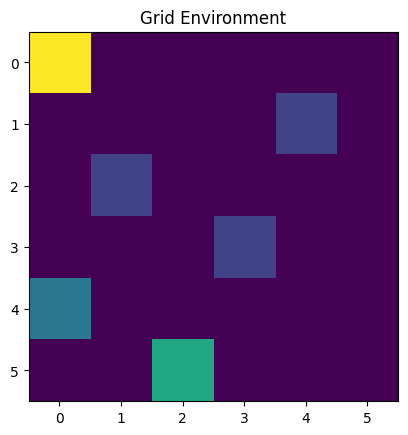

Timestep: 0
Reward: 0
Cumulative Reward: 0
Item Co-ords: [4, 0]
Agent Co-ords: [0, 0]
Goal Co-ords: [5, 2]
Goal Achieved: 0
Goal Achieved: 0
Last action taken: null


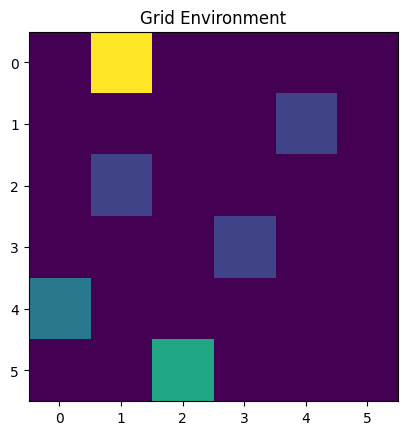

Timestep: 1
Reward: -1
Cumulative Reward: -1
Item Co-ords: [4, 0]
Agent Co-ords: [0, 1]
Goal Co-ords: [5, 2]
Goal Achieved: 0
Goal Achieved: 0
Last action taken: Right


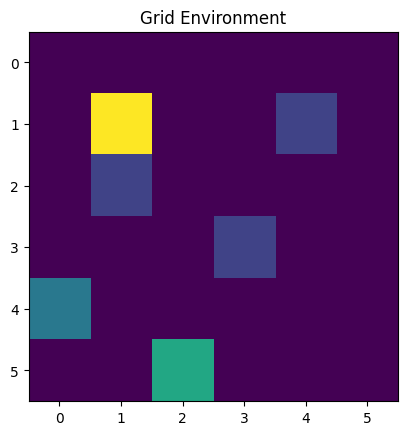

Timestep: 2
Reward: -1
Cumulative Reward: -2
Item Co-ords: [4, 0]
Agent Co-ords: [1, 1]
Goal Co-ords: [5, 2]
Goal Achieved: 0
Goal Achieved: 0
Last action taken: Down


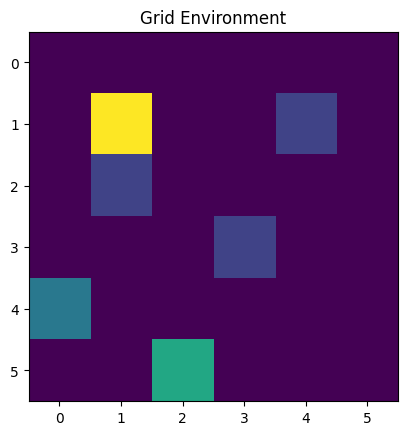

Timestep: 3
Reward: 0
Cumulative Reward: -2
Item Co-ords: [4, 0]
Agent Co-ords: [1, 1]
Goal Co-ords: [5, 2]
Goal Achieved: 0
Goal Achieved: 0
Last action taken: Dropoff


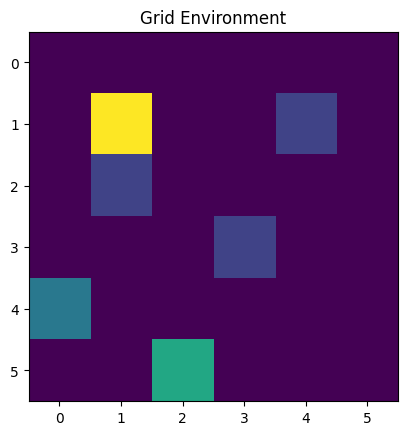

Timestep: 4
Reward: 0
Cumulative Reward: -2
Item Co-ords: [4, 0]
Agent Co-ords: [1, 1]
Goal Co-ords: [5, 2]
Goal Achieved: 0
Goal Achieved: 0
Last action taken: Dropoff


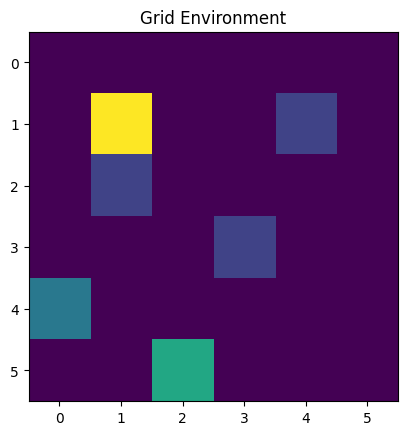

Timestep: 5
Reward: 0
Cumulative Reward: -2
Item Co-ords: [4, 0]
Agent Co-ords: [1, 1]
Goal Co-ords: [5, 2]
Goal Achieved: 0
Goal Achieved: 0
Last action taken: Pickup


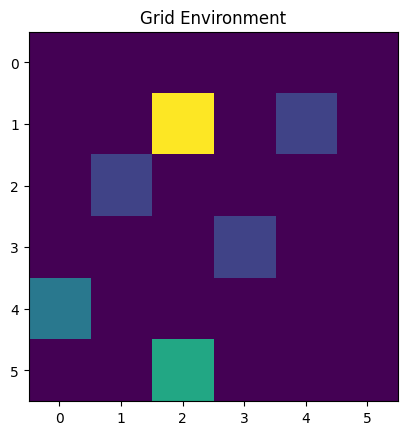

Timestep: 6
Reward: -1
Cumulative Reward: -3
Item Co-ords: [4, 0]
Agent Co-ords: [1, 2]
Goal Co-ords: [5, 2]
Goal Achieved: 0
Goal Achieved: 0
Last action taken: Right


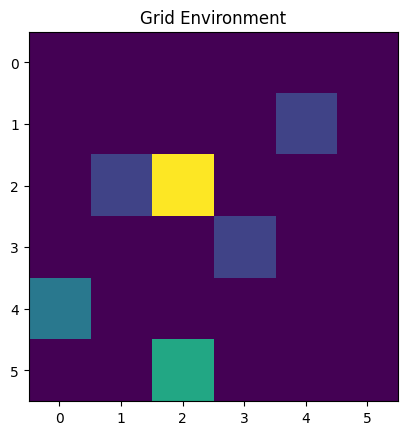

Timestep: 7
Reward: -1
Cumulative Reward: -4
Item Co-ords: [4, 0]
Agent Co-ords: [2, 2]
Goal Co-ords: [5, 2]
Goal Achieved: 0
Goal Achieved: 0
Last action taken: Down


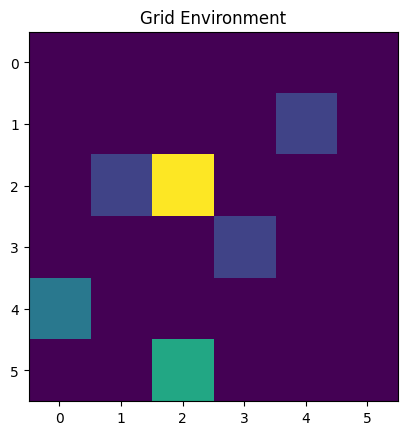

Timestep: 8
Reward: 0
Cumulative Reward: -4
Item Co-ords: [4, 0]
Agent Co-ords: [2, 2]
Goal Co-ords: [5, 2]
Goal Achieved: 0
Goal Achieved: 0
Last action taken: Dropoff


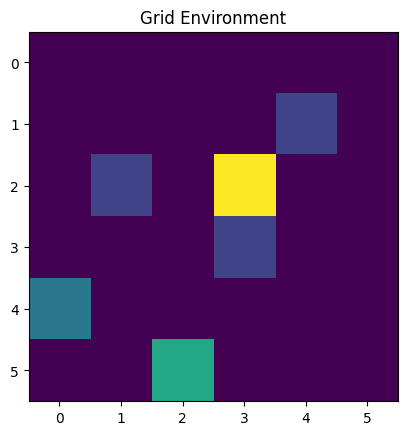

Timestep: 9
Reward: -1
Cumulative Reward: -5
Item Co-ords: [4, 0]
Agent Co-ords: [2, 3]
Goal Co-ords: [5, 2]
Goal Achieved: 0
Goal Achieved: 0
Last action taken: Right


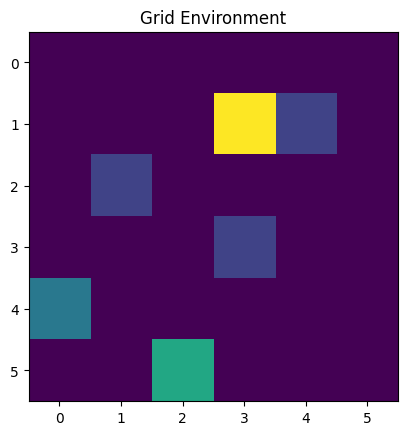

Timestep: 10
Reward: -1
Cumulative Reward: -6
Item Co-ords: [4, 0]
Agent Co-ords: [1, 3]
Goal Co-ords: [5, 2]
Goal Achieved: 0
Goal Achieved: 0
Last action taken: Up


In [4]:
env = GridEnvironment()
agent = RandomAgent(env)

obs = env.reset()
    
env.render()

for i in range(10):
    action = agent.step(obs)
    obs, reward, terminated = env.step(action)
    env.render()


### Implementing Deep Q Learning

In [5]:
import torch
from torch import nn
from torch import optim
from collections import deque

In [12]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 100)
        self.fc2 = nn.Linear(100, 200)
        self.fc3 = nn.Linear(200, action_size)
    def forward(self, state):
        x = torch.relu(self.fc1(torch.tensor(state)))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [13]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, state, action, reward, next_state, terminated):
        experience_tuple = (state, action, reward, next_state, terminated)
        self.memory.append(experience_tuple)    
    def __len__(self):
        return len(self.memory)
    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, terminated = (zip(*batch))
#         return states, actions, rewards, next_states, terminated
        states_tensor = torch.tensor(states, dtype=torch.float32)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32)
        terminated_tensor = torch.tensor(terminated, dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, terminated_tensor

In [234]:
replay_buffer = ReplayBuffer(1000)
step = 0
total_steps = 0

n_episodes = 1000 
batch_size = 100  
gamma = 0.9  
lr = 0.001  
target_update_frequency = 300 
min_exploration_proba = 0.01  
exploration_proba = 0.99  
exploration_decreasing_decay = 0.0015   
epsilon_values_deterministic = []
rewards_per_episode_deterministic = []

online_network = QNetwork(36, 6)
target_network = QNetwork(36, 6)
target_network.load_state_dict(online_network.state_dict())  
optimizer = optim.Adam(online_network.parameters(), lr=lr)

env = GridEnvironment()
total_steps = 0
for e in range(n_episodes):
    print(e)
    current_state = env.reset()
    terminated = False
    total_episode_reward = 0
    while not terminated: 
        total_steps += 1
        
        # Selecting action using epsilon-greedy policy
        if np.random.rand() < exploration_proba:
            action = env.action_space.sample()  
        else:
            with torch.no_grad():
                action = online_network(torch.tensor(current_state, dtype=torch.float)).argmax().item() 

        # Perform the action
        next_state, reward, terminated = env.step(action)
        
        
        # Store experience in replay buffer
        replay_buffer.push(current_state, action, reward, next_state, terminated)
        
        # Perform learning step if replay buffer has enough samples
        if len(replay_buffer) >= batch_size:
            # Sample minibatch from the replay buffer
            states, actions, rewards, next_states, terminated_ = replay_buffer.sample(batch_size)

            # Computing Q-values for the current states
            q_values = online_network(states).gather(1, actions).squeeze(1)

            
            # Computing target Q-values for the next states
            with torch.no_grad():
                next_q_values = target_network(next_states).max(1)[0]
#                 print("next_q_values", next_q_values)
                target_q_values = rewards + gamma * next_q_values * (1 - terminated_)
            
            # Computing loss and perform backpropagation
            loss = nn.MSELoss()(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Hard update the target network every fixed number of steps
        if total_steps % target_update_frequency == 0:
            target_network.load_state_dict(online_network.state_dict())
        
        # Updating total reward for the episode
        total_episode_reward += reward
        
        # Moving to the next state
        current_state = next_state
    
    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay * (e*2)))
    print(exploration_proba)
    epsilon_values_deterministic.append(exploration_proba)
    rewards_per_episode_deterministic.append(total_episode_reward)


0


/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_1303/2160088662.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


1.0
1
0.997004495503373
2
0.9940179640539353
3
0.9910403787728836
4
0.9880717128619305
5
0.9851119396030626
6
0.9821610323583008
7
0.9792189645694596
8
0.9762857097579093
9
0.9733612415243368
10
0.9704455335485082
11
0.967538559589032
12
0.9646402934831231
13
0.9617507091463667
14
0.9588697805724845
15
0.9559974818331
16
0.9531337870775047
17
0.950278670532427
18
0.9474321065017983
19
0.9445940693665233
20
0.9417645335842487
21
0.9389434736891332
22
0.9361308642916188
23
0.933326680078202
24
0.9305308958112057
25
0.9277434863285529
26
0.9249644265435393
27
0.922193691444608
28
0.9194312560951247
29
0.9166770956331523
30
0.9139311852712282
31
0.9111935002961405
32
0.9084640160687062
33
0.9057427080235485
34
0.9030295516688768
35
0.9003245225862656
36
0.8976275964304349
37
0.894938748929031
38
0.8922579558824083
39
0.8895851931634113
40
0.8869204367171575
41
0.8842636625608209
42
0.8816148467834161
43
0.8789739655455832
44
0.8763409950793732
45
0.8737159116880344
46
0.8710986917457983
47

0.336552878364737
364
0.3355447327042427
365
0.3345396069486076
366
0.3335374920516932
367
0.3325383789944587
368
0.3315422587848797
369
0.3305491224578677
370
0.32955896107518906
371
0.3285717657253846
372
0.3275875275236895
373
0.3266062376119534
374
0.32562788715856034
375
0.32465246735834974
376
0.3236799694325367
377
0.3227103846286335
378
0.32174370422037013
379
0.3207799195076166
380
0.31981902181630384
381
0.3188610024983463
382
0.3179058529315635
383
0.31695356451960294
384
0.31600412869186245
385
0.3150575369034133
386
0.31411378063492296
387
0.3131728513925785
388
0.31223474070801055
389
0.3112994401382165
390
0.31036694126548503
391
0.30943723569731985
392
0.3085103150663647
393
0.3075861710303276
394
0.306664795271906
395
0.30574617949871175
396
0.30483031544319683
397
0.3039171948625785
398
0.3030068095387654
399
0.3020991512782834
400
0.30119421191220214
401
0.30029198329606105
402
0.2993924573097967
403
0.2984956258576689
404
0.29760148086818883
405
0.29671001429404525


0.11567161588357389
720
0.11532512103806251
721
0.11497966411941893
722
0.11463524201852858
723
0.11429185163559014
724
0.11394948988008788
725
0.11360815367076371
726
0.11326783993558948
727
0.11292854561173918
728
0.11259026764556165
729
0.11225300299255297
730
0.11191674861732888
731
0.11158150149359779
732
0.1112472586041333
733
0.11091401694074722
734
0.11058177350426224
735
0.11025052530448522
736
0.10992026936018012
737
0.10959100269904129
738
0.10926272235766643
739
0.10893542538153032
740
0.10860910882495796
741
0.10828376975109819
742
0.10795940523189702
743
0.10763601234807169
744
0.10731358818908403
745
0.10699212985311449
746
0.10667163444703576
747
0.1063520990863871
748
0.1060335208953481
749
0.10571589700671291
750
0.10539922456186433
751
0.10508350071074826
752
0.10476872261184789
753
0.10445488743215826
754
0.10414199234716055
755
0.10383003454079692
756
0.10351901120544502
757
0.10320891954189276
758
0.102899756759313
759
0.10259152007523863
760
0.10228420671553744
7

In [235]:
import pickle
online_weights = online_network.state_dict()
target_weights = target_network.state_dict()

online_network.state_dict()

with open('online_network_weights_Robot.pkl', 'wb') as file:
    pickle.dump(online_weights, file)
    
with open('target_network_weights_Robot.pkl', 'wb') as file:
    pickle.dump(target_weights, file)

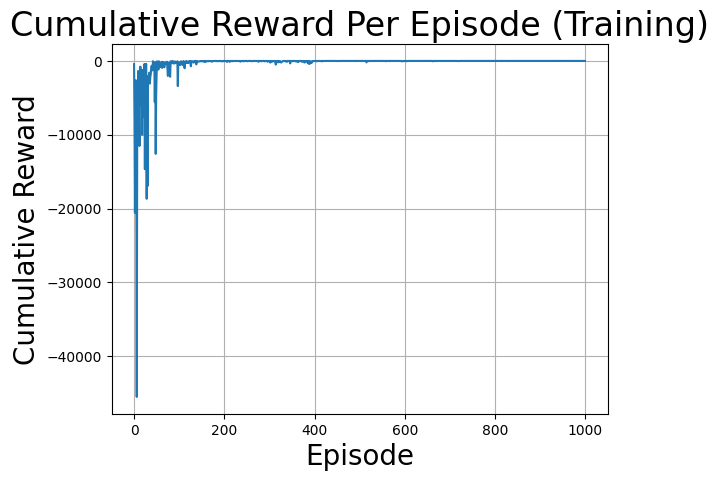

In [236]:
# Reward Dynamics
plt.figure()
plt.plot(rewards_per_episode_deterministic)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode (Training)', fontsize=24)
plt.grid()
plt.show()

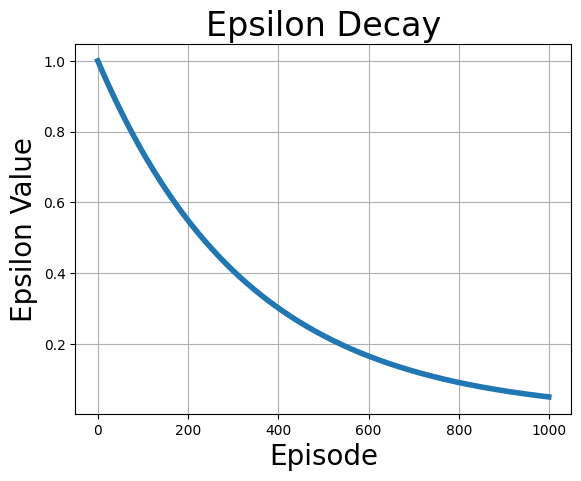

In [237]:
# Epsilon-decay graph
plt.figure()
plt.plot(epsilon_values_deterministic, linewidth=4)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Epsilon Value', fontsize=20)
plt.title('Epsilon Decay', fontsize=24)
plt.grid()
plt.show()

### Running the optimal policy for 10 episodes

In [238]:
n_episodes = 5  
epsilon_values_deterministic = []
rewards_per_episode_testing = []


for e in range(n_episodes):
    current_state = env.reset()
    terminated = False
    total_episode_reward = 0
    total_steps = 0
    
    while not terminated: 
        total_steps += 1
        
        with torch.no_grad():
            action = online_network(torch.tensor(current_state, dtype=torch.float)).argmax().item() 

        next_state, reward, terminated = env.step(action)
        
        total_episode_reward += reward
        
        current_state = next_state
    
    rewards_per_episode_testing.append(total_episode_reward)


/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_1303/2160088662.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


Text(0, 0.5, 'Reward')

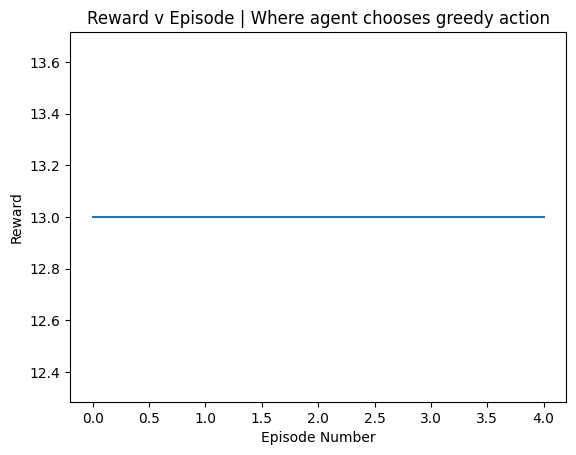

In [261]:
plt.plot(rewards_per_episode_testing)
plt.title('Reward v Episode | Where agent chooses greedy action')
plt.xlabel('Episode Number')
plt.ylabel('Reward')


# Applying DDQN to the Robot Grid Environment

In [24]:
import torch.nn.functional as F
class DDQNQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DDQNQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, action_size)
    def forward(self, state):
        x = F.leaky_relu(self.fc1(torch.tensor(state)), negative_slope=0.02)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.02)
        return self.fc3(x)

In [201]:
replay_buffer = ReplayBuffer(2500)
step = 0
total_steps = 0

n_episodes = 1000 
batch_size = 200  
gamma = 0.95  
lr = 0.001  
target_update_frequency = 800 
min_exploration_proba = 0.01  
exploration_proba = 0.99  
exploration_decreasing_decay = 0.0015   
epsilon_values_DDQN = []
rewards_per_episode_DDQN = []

online_network_DDQN = DDQNQNetwork(36, 6)
target_network_DDQN = DDQNQNetwork(36, 6)
target_network_DDQN.load_state_dict(online_network_DDQN.state_dict())  
optimizer = optim.Adam(online_network_DDQN.parameters(), lr=lr)

env = GridEnvironment()
total_steps = 0
for e in range(n_episodes):
    print(exploration_proba, e)
    current_state = env.reset()
    terminated = False
    total_episode_reward = 0
    while not terminated: 
        total_steps += 1
        
        # Selecting action using epsilon-greedy policy
        if np.random.rand() < exploration_proba:
            action = env.action_space.sample()  
        else:
            with torch.no_grad():
                action = online_network_DDQN(torch.tensor(current_state, dtype=torch.float)).argmax().item() 

        # Perform the action
        next_state, reward, terminated = env.step(action)
        
        
        # Store experience in replay buffer
        replay_buffer.push(current_state, action, reward, next_state, terminated)
        
        # Perform learning step if replay buffer has enough samples
        if len(replay_buffer) >= batch_size:
            # Sample minibatch from the replay buffer
            states, actions, rewards, next_states, terminated_ = replay_buffer.sample(batch_size)

            # Computing Q-values for the current states
            q_values = online_network_DDQN(states).gather(1, actions).squeeze(1)

            
            # Computing target Q-values for the next states
            with torch.no_grad():
                next_actions = online_network_DDQN(next_states).argmax(1).unsqueeze(1)
                next_q_values = target_network_DDQN(next_states).gather(1, next_actions).squeeze(1)


                target_q_values = rewards + gamma * next_q_values * (1 - terminated_)
            
            # Computing loss and perform backpropagation
            loss = nn.MSELoss()(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Hard update the target network every fixed number of steps
        if total_steps % target_update_frequency == 0:
            target_network_DDQN.load_state_dict(online_network_DDQN.state_dict())
        
        # Updating total reward for the episode
        total_episode_reward += reward
        
        # Moving to the next state
        current_state = next_state
    
#     exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay * e))
    exploration_proba = max(min_exploration_proba, exploration_proba * (1 - exploration_decreasing_decay))
    epsilon_values_DDQN.append(exploration_proba)
    rewards_per_episode_DDQN.append(total_episode_reward)

0.99 0


/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_1303/2742317936.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = F.leaky_relu(self.fc1(torch.tensor(state)), negative_slope=0.02)


0.988515 1
0.9870322275000001 2
0.9855516791587501 3
0.984073351640012 4
0.982597241612552 5
0.9811233457501333 6
0.9796516607315081 7
0.978182183240411 8
0.9767149099655504 9
0.9752498376006021 10
0.9737869628442013 11
0.972326282399935 12
0.9708677929763352 13
0.9694114912868708 14
0.9679573740499405 15
0.9665054379888657 16
0.9650556798318825 17
0.9636080963121347 18
0.9621626841676666 19
0.9607194401414152 20
0.9592783609812031 21
0.9578394434397314 22
0.9564026842745719 23
0.95496808024816 24
0.9535356281277878 25
0.9521053246855962 26
0.9506771666985678 27
0.9492511509485201 28
0.9478272742220973 29
0.9464055333107643 30
0.9449859250107981 31
0.943568446123282 32
0.942153093454097 33
0.9407398638139159 34
0.9393287540181952 35
0.9379197608871679 36
0.9365128812458372 37
0.9351081119239685 38
0.9337054497560826 39
0.9323048915814486 40
0.9309064342440765 41
0.9295100745927104 42
0.9281158094808214 43
0.9267236357666002 44
0.9253335503129504 45
0.923945549987481 46
0.92255963166249

0.5698029097472759 368
0.568948205382655 369
0.5680947830745811 370
0.5672426408999692 371
0.5663917769386193 372
0.5655421892732114 373
0.5646938759893017 374
0.5638468351753178 375
0.5630010649225548 376
0.5621565633251709 377
0.5613133284801832 378
0.560471358487463 379
0.5596306514497318 380
0.5587912054725572 381
0.5579530186643484 382
0.5571160891363519 383
0.5562804150026475 384
0.5554459943801435 385
0.5546128253885734 386
0.5537809061504906 387
0.5529502347912649 388
0.552120809439078 389
0.5512926282249194 390
0.5504656892825821 391
0.5496399907486582 392
0.5488155307625353 393
0.5479923074663915 394
0.547170319005192 395
0.5463495635266842 396
0.5455300391813942 397
0.5447117441226221 398
0.5438946765064382 399
0.5430788344916786 400
0.5422642162399411 401
0.5414508199155813 402
0.5406386436857079 403
0.5398276857201794 404
0.5390179441915991 405
0.5382094172753117 406
0.5374021031493987 407
0.5365959999946747 408
0.5357911059946827 409
0.5349874193356907 410
0.5341849382066

0.3349200611656294 722
0.334417681073881 723
0.3339160545522702 724
0.33341518047044183 725
0.33291505769973617 726
0.3324156851131866 727
0.3319170615855168 728
0.3314191859931386 729
0.3309220572141489 730
0.3304256741283277 731
0.3299300356171352 732
0.3294351405637095 733
0.32894098785286396 734
0.3284475763710847 735
0.3279549050065281 736
0.3274629726490183 737
0.3269717781900448 738
0.32648132052275974 739
0.3259915985419756 740
0.3255026111441627 741
0.3250143572274464 742
0.3245268356916053 743
0.3240400454380679 744
0.3235539853699108 745
0.32306865439185595 746
0.3225840514102682 747
0.3221001753331528 748
0.3216170250701531 749
0.3211345995325479 750
0.3206528976332491 751
0.32017191828679925 752
0.3196916604093691 753
0.31921212291875506 754
0.31873330473437694 755
0.31825520477727537 756
0.31777782197010945 757
0.3173011552371543 758
0.3168252035042986 759
0.31634996569904217 760
0.3158754407504936 761
0.3154016275893679 762
0.31492852514798386 763
0.31445613236026193 764

In [267]:
import pickle
online_weights = online_network_DDQN.state_dict()
target_weights = target_network_DDQN.state_dict()

with open('online_network_weights_Robot_DQN.pkl', 'wb') as file:
    pickle.dump(online_weights, file)
    
with open('target_network_weights_Robot_DQN.pkl', 'wb') as file:
    pickle.dump(target_weights, file)

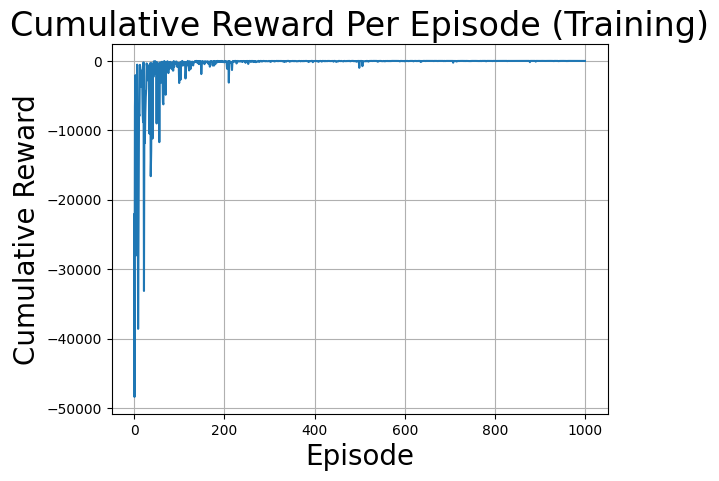

In [262]:
# Reward Dynamics
plt.figure()
plt.plot(rewards_per_episode_DDQN)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode (Training)', fontsize=24)
plt.grid()
plt.show()

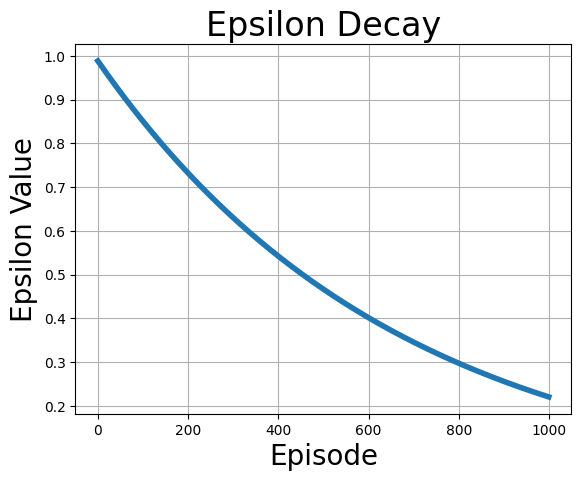

In [242]:
# Epsilon-decay graph
plt.figure()
plt.plot(epsilon_values_DDQN, linewidth=4)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Epsilon Value', fontsize=20)
plt.title('Epsilon Decay', fontsize=24)
plt.grid()
plt.show()

In [243]:
n_episodes = 5  
epsilon_values_deterministic = []
rewards_per_episode_testing_DDQN = []


for e in range(n_episodes):
    current_state = env.reset()
    terminated = False
    total_episode_reward = 0
    total_steps = 0
    
    while not terminated: 
        total_steps += 1
        
        with torch.no_grad():
            action = online_network_DDQN(torch.tensor(current_state, dtype=torch.float)).argmax().item() 

        next_state, reward, terminated = env.step(action)
        
        total_episode_reward += reward
        
        current_state = next_state
    
    rewards_per_episode_testing_DDQN.append(total_episode_reward)

/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_1303/2742317936.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = F.leaky_relu(self.fc1(torch.tensor(state)), negative_slope=0.02)


Text(0, 0.5, 'Reward')

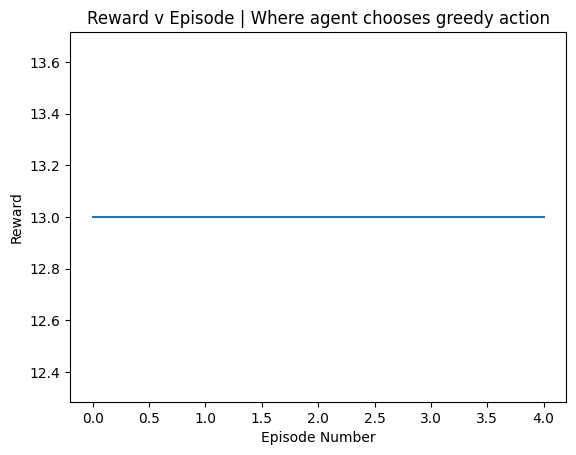

In [244]:
plt.plot(rewards_per_episode_testing_DDQN)
plt.title('Reward v Episode | Where agent chooses greedy action')
plt.xlabel('Episode Number')
plt.ylabel('Reward')

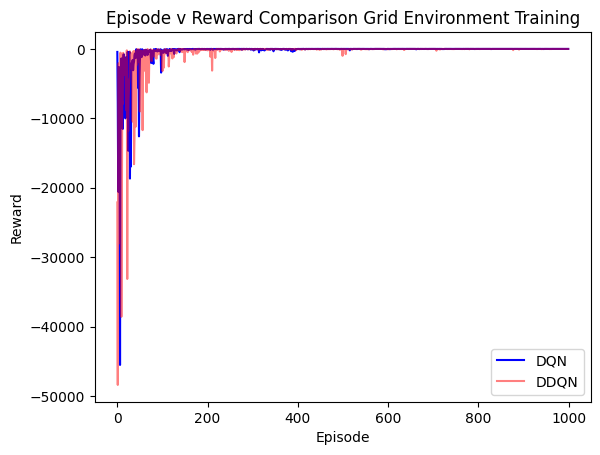

In [263]:
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode_deterministic, label="DQN", color="blue")
plt.plot(rewards_per_episode_DDQN, label="DDQN", color="red", alpha = 0.5)

plt.legend()

# Adding labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode v Reward Comparison Grid Environment Training")

# Display the plot
plt.show()

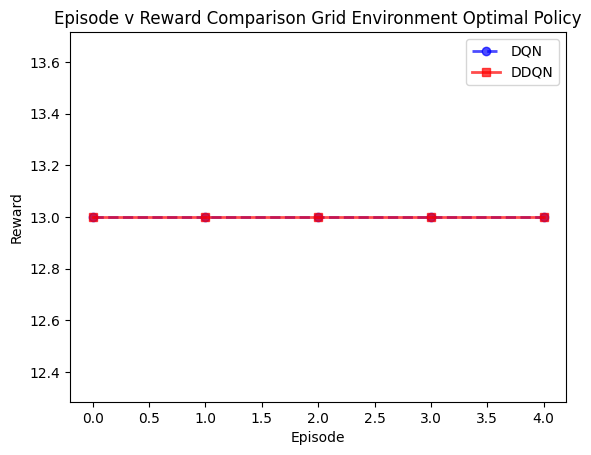

In [268]:
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode_testing, label="DQN", color="blue", linestyle="--", marker="o", alpha=0.7, linewidth=2)
plt.plot(rewards_per_episode_testing_DDQN, label="DDQN", color="red", linestyle="-", marker="s", alpha=0.7, linewidth=2)

plt.legend()

# Adding labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode v Reward Comparison Grid Environment Optimal Policy")

# Display the plot
plt.show()

# Applying Deep Q Networks on Cartpole

In [36]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [249]:
class ReplayBufferCartpole:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, state, action, reward, next_state, terminated, truncated):
        experience_tuple = (state, action, reward, next_state, terminated, truncated)
        self.memory.append(experience_tuple)    
    def __len__(self):
        return len(self.memory)
    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, terminated, truncated = (zip(*batch))
        states_tensor = torch.tensor(states, dtype=torch.float32)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32)
        terminated_tensor = torch.tensor(terminated, dtype=torch.float32)
        truncated_tensor = torch.tensor(truncated, dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, terminated_tensor, truncated_tensor

In [250]:
class QNetworkCartpole(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetworkCartpole, self).__init__()
        self.fc1 = nn.Linear(state_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, action_size)
    def forward(self, state):
        x = torch.relu(self.fc1(torch.tensor(state)))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [252]:
replay_buffer = ReplayBufferCartpole(4000)
step = 0
total_steps = 0

n_episodes = 1000 
batch_size = 200  
gamma = 0.95  
lr = 0.001  
target_update_frequency = 800 
min_exploration_proba = 0.01  
exploration_proba = 0.99  
exploration_decreasing_decay = 0.0015  
epsilon_values_cartpole = []
rewards_per_episode_cartpole = []

online_network_cartpole = QNetworkCartpole(4, 2)
target_network_cartpole = QNetworkCartpole(4, 2)
target_network_cartpole.load_state_dict(online_network_cartpole.state_dict())  
optimizer = optim.Adam(online_network_cartpole.parameters(), lr=lr)

env = gym.make("CartPole-v1", render_mode="rgb_array")
total_steps = 0

for e in range(n_episodes):
    current_state, info = env.reset()
    terminated = False
    total_episode_reward = 0
    truncated = False
    print("episode:", e, "Eps:", exploration_proba)
    while not terminated and not truncated: 
        total_steps += 1
        
        # Selecting action using epsilon-greedy policy
        if np.random.rand() < exploration_proba:
            action = env.action_space.sample()  
        else:
            with torch.no_grad():
                action = online_network_cartpole(torch.tensor(current_state, dtype=torch.float)).argmax().item()
                

        # Perform the action
        next_state, reward, terminated, truncated, info = env.step(action)
        
        
        # Store experience in replay buffer
        replay_buffer.push(current_state, action, reward, next_state, terminated, truncated)
        
        # Perform learning step if replay buffer has enough samples
        if len(replay_buffer) >= batch_size:
            # Sample minibatch from the replay buffer
            states, actions, rewards, next_states, terminated_, truncated_ = replay_buffer.sample(batch_size)

            # Computing Q-values for the current states
            q_values = online_network_cartpole(torch.tensor(states, dtype=torch.float)).gather(1, actions).squeeze(1)
            

            
            # Computing target Q-values for the next states
            with torch.no_grad():
                next_q_values = target_network_cartpole(torch.tensor(next_states, dtype=torch.float)).max(1)[0]
                target_q_values = rewards + gamma * next_q_values * (1 - terminated_)
            
            # Computing loss and perform backpropagation
            loss = nn.MSELoss()(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Hard update the target network every fixed number of steps
        if total_steps % target_update_frequency == 0:
            target_network_cartpole.load_state_dict(online_network_cartpole.state_dict())
        
        # Updating total reward for the episode
        total_episode_reward += reward
        
        # Moving to the next state
        current_state = next_state
    
    
    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay * e))
    epsilon_values_cartpole.append(exploration_proba)
    rewards_per_episode_cartpole.append(total_episode_reward)


episode: 0 Eps: 0.99
episode: 1 Eps: 1.0
episode: 2 Eps: 0.9985011244377109
episode: 3 Eps: 0.997004495503373
episode: 4 Eps: 0.9955101098295706
episode: 5 Eps: 0.9940179640539353
episode: 6 Eps: 0.9925280548191384
episode: 7 Eps: 0.9910403787728836
episode: 8 Eps: 0.9895549325678993
episode: 9 Eps: 0.9880717128619305
episode: 10 Eps: 0.9865907163177327
episode: 11 Eps: 0.9851119396030626
episode: 12 Eps: 0.9836353793906724
episode: 13 Eps: 0.9821610323583008
episode: 14 Eps: 0.9806888951886662


/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_1303/69166130.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))
/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_1303/986971309.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_values = online_network_cartpole(torch.tensor(states, dtype=torch.float)).gather(1, actions).squeeze(1)
/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_1303/986971309.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_q_values

episode: 15 Eps: 0.9792189645694596
episode: 16 Eps: 0.9777512371933363
episode: 17 Eps: 0.9762857097579093
episode: 18 Eps: 0.9748223789657411
episode: 19 Eps: 0.9733612415243368
episode: 20 Eps: 0.9719022941461366
episode: 21 Eps: 0.9704455335485082
episode: 22 Eps: 0.9689909564537397
episode: 23 Eps: 0.967538559589032
episode: 24 Eps: 0.9660883396864915
episode: 25 Eps: 0.9646402934831231
episode: 26 Eps: 0.9631944177208218
episode: 27 Eps: 0.9617507091463667
episode: 28 Eps: 0.960309164511413
episode: 29 Eps: 0.9588697805724845
episode: 30 Eps: 0.957432554090967
episode: 31 Eps: 0.9559974818331
episode: 32 Eps: 0.9545645605699703
episode: 33 Eps: 0.9531337870775047
episode: 34 Eps: 0.9517051581364622
episode: 35 Eps: 0.950278670532427
episode: 36 Eps: 0.9488543210558013
episode: 37 Eps: 0.9474321065017983
episode: 38 Eps: 0.9460120236704347
episode: 39 Eps: 0.9445940693665233
episode: 40 Eps: 0.9431782403996666
episode: 41 Eps: 0.9417645335842487
episode: 42 Eps: 0.9403529457394286

episode: 241 Eps: 0.697676326071031
episode: 242 Eps: 0.6966305960754955
episode: 243 Eps: 0.6955864334990951
episode: 244 Eps: 0.6945438359924634
episode: 245 Eps: 0.6935028012097558
episode: 246 Eps: 0.6924633268086434
episode: 247 Eps: 0.6914254104503085
episode: 248 Eps: 0.6903890497994388
episode: 249 Eps: 0.6893542425242224
episode: 250 Eps: 0.6883209862963425
episode: 251 Eps: 0.6872892787909722
episode: 252 Eps: 0.6862591176867691
episode: 253 Eps: 0.6852305006658703
episode: 254 Eps: 0.6842034254138871
episode: 255 Eps: 0.6831778896198997
episode: 256 Eps: 0.6821538909764522
episode: 257 Eps: 0.6811314271795471
episode: 258 Eps: 0.6801104959286406
episode: 259 Eps: 0.6790910949266368
episode: 260 Eps: 0.6780732218798831
episode: 261 Eps: 0.6770568744981647
episode: 262 Eps: 0.6760420504946996
episode: 263 Eps: 0.6750287475861332
episode: 264 Eps: 0.6740169634925337
episode: 265 Eps: 0.6730066959373864
episode: 266 Eps: 0.6719979426475889
episode: 267 Eps: 0.6709907013534459
ep

episode: 464 Eps: 0.4993240476038332
episode: 465 Eps: 0.4985756229912165
episode: 466 Eps: 0.49782832017396195
episode: 467 Eps: 0.4970821374706377
episode: 468 Eps: 0.49633707320233256
episode: 469 Eps: 0.4955931256926514
episode: 470 Eps: 0.49485029326771224
episode: 471 Eps: 0.4941085742561417
episode: 472 Eps: 0.49336796698907165
episode: 473 Eps: 0.49262846980013547
episode: 474 Eps: 0.4918900810254641
episode: 475 Eps: 0.4911527990036827
episode: 476 Eps: 0.49041662207590614
episode: 477 Eps: 0.4896815485857362
episode: 478 Eps: 0.4889475768792571
episode: 479 Eps: 0.4882147053050323
episode: 480 Eps: 0.4874829322141004
episode: 481 Eps: 0.4867522559599717
episode: 482 Eps: 0.4860226748986241
episode: 483 Eps: 0.4852941873885002
episode: 484 Eps: 0.4845667917905026
episode: 485 Eps: 0.483840486467991
episode: 486 Eps: 0.48311526978677805
episode: 487 Eps: 0.4823911401151259
episode: 488 Eps: 0.48166809582374254
episode: 489 Eps: 0.480946135285778
episode: 490 Eps: 0.480225256876

episode: 693 Eps: 0.35416229870357024
episode: 694 Eps: 0.3536314534889593
episode: 695 Eps: 0.353101403945268
episode: 696 Eps: 0.3525721488798844
episode: 697 Eps: 0.3520436871019846
episode: 698 Eps: 0.35151601742252925
episode: 699 Eps: 0.35098913865426146
episode: 700 Eps: 0.35046304961170366
episode: 701 Eps: 0.3499377491111553
episode: 702 Eps: 0.34941323597069013
episode: 703 Eps: 0.34888950901015336
episode: 704 Eps: 0.348366567051159
episode: 705 Eps: 0.3478444089170874
episode: 706 Eps: 0.3473230334330827
episode: 707 Eps: 0.34680243942604977
episode: 708 Eps: 0.3462826257246518
episode: 709 Eps: 0.34576359115930777
episode: 710 Eps: 0.34524533456218975
episode: 711 Eps: 0.3447278547672202
episode: 712 Eps: 0.34421115061006924
episode: 713 Eps: 0.34369522092815236
episode: 714 Eps: 0.34318006456062755
episode: 715 Eps: 0.3426656803483929
episode: 716 Eps: 0.34215206713408347
episode: 717 Eps: 0.34163922376206945
episode: 718 Eps: 0.3411271490784531
episode: 719 Eps: 0.340615

episode: 913 Eps: 0.2546156820248037
episode: 914 Eps: 0.25423404480124123
episode: 915 Eps: 0.2538529796043867
episode: 916 Eps: 0.2534724855768434
episode: 917 Eps: 0.25309256186249957
episode: 918 Eps: 0.25271320760652677
episode: 919 Eps: 0.25233442195537764
episode: 920 Eps: 0.2519562040567843
episode: 921 Eps: 0.25157855305975646
episode: 922 Eps: 0.2512014681145792
episode: 923 Eps: 0.2508249483728111
episode: 924 Eps: 0.2504489929872826
episode: 925 Eps: 0.2500736011120941
episode: 926 Eps: 0.24969877190261355
episode: 927 Eps: 0.2493245045154751
episode: 928 Eps: 0.24895079810857698
episode: 929 Eps: 0.24857765184107966
episode: 930 Eps: 0.24820506487340388
episode: 931 Eps: 0.24783303636722875
episode: 932 Eps: 0.24746156548548998
episode: 933 Eps: 0.24709065139237796
episode: 934 Eps: 0.24672029325333586
episode: 935 Eps: 0.24635049023505762
episode: 936 Eps: 0.24598124150548634
episode: 937 Eps: 0.2456125462338122
episode: 938 Eps: 0.24524440359047078
episode: 939 Eps: 0.24

In [279]:
import pickle
online_weights = online_network_cartpole.state_dict()
target_weights = target_network_cartpole.state_dict()

online_network.state_dict()

with open('online_network_weights_Cartpole.pkl', 'wb') as file:
    pickle.dump(online_weights, file)
    
with open('target_network_weights_Cartpole.pkl', 'wb') as file:
    pickle.dump(target_weights, file)

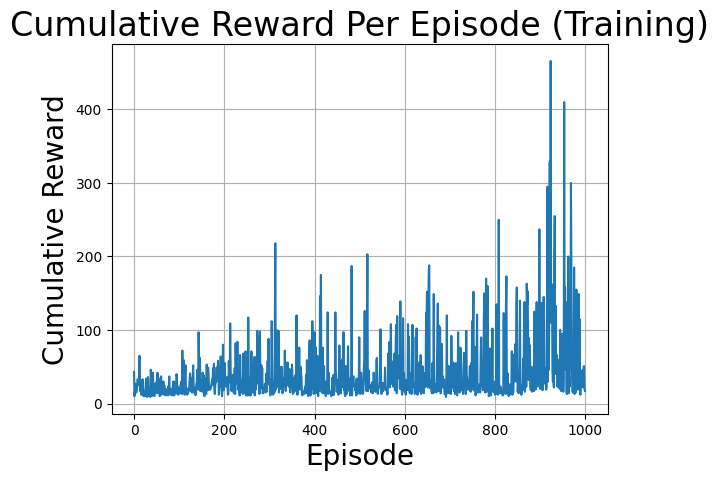

In [254]:
plt.figure()
plt.plot(rewards_per_episode_cartpole)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode (Training)', fontsize=24)
plt.grid()
plt.show()

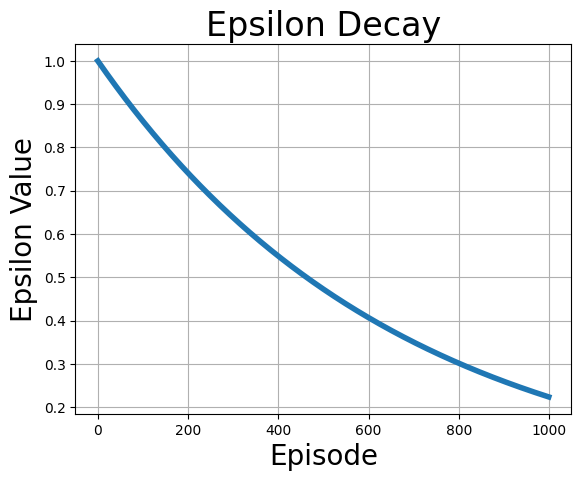

In [255]:
# Epsilon-decay graph
plt.figure()
plt.plot(epsilon_values_cartpole, linewidth=4)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Epsilon Value', fontsize=20)
plt.title('Epsilon Decay', fontsize=24)
plt.grid()
plt.show()

# Running opimal policy on cartpole 

In [256]:
n_episodes = 10  
rewards_per_episode_testing_cart = []
env = gym.make("CartPole-v1", render_mode="rgb_array")

for e in range(n_episodes):
    current_state, info = env.reset()
    terminated = False
    total_episode_reward = 0
    total_steps = 0
    
    while not terminated: 
        total_steps += 1
        
        with torch.no_grad():
            action = online_network_cartpole(torch.tensor(current_state, dtype=torch.float)).argmax().item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        
        total_episode_reward += reward
        
        current_state = next_state
    
    rewards_per_episode_testing_cart.append(total_episode_reward)

/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_1303/69166130.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


Text(0, 0.5, 'Reward')

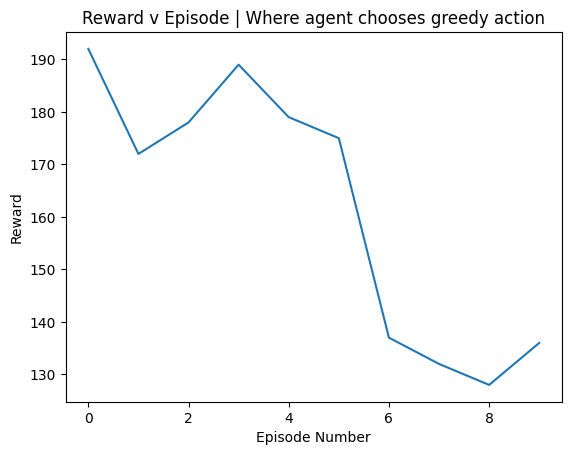

In [257]:
plt.plot(rewards_per_episode_testing_cart)
plt.title('Reward v Episode | Where agent chooses greedy action')
plt.xlabel('Episode Number')
plt.ylabel('Reward')

# Applying DDQN On CartPole

In [190]:
replay_buffer = ReplayBufferCartpole(10000)
step = 0
total_steps = 0

n_episodes = 1000 
batch_size = 64  
gamma = 0.95  
lr = 0.0001  
target_update_frequency = 700 
min_exploration_proba = 0.01  
exploration_proba = 0.99  
exploration_decreasing_decay = 0.0015  
epsilon_values_cartpole_DDQN = []
rewards_per_episode_cartpole_DDQN = []

online_network_cartpole_DDQN = QNetworkCartpole(4, 2)
target_network_cartpole_DDQN = QNetworkCartpole(4, 2)
target_network_cartpole_DDQN.load_state_dict(online_network_cartpole_DDQN.state_dict())  
optimizer = optim.Adam(online_network_cartpole_DDQN.parameters(), lr=lr)

env = gym.make("CartPole-v1", render_mode="rgb_array")

for e in range(n_episodes):
    current_state, info = env.reset()
    terminated = False
    total_episode_reward = 0
    total_steps = 0
    truncated = False
    print("episode:", e, "eps:", exploration_proba)
    while not terminated and not truncated: 
        
        total_steps += 1
        
        # Selecting action using epsilon-greedy policy
        if np.random.rand() < exploration_proba:
            action = env.action_space.sample()  
        else:
            with torch.no_grad():
                action = online_network_cartpole_DDQN(torch.tensor(current_state, dtype=torch.float)).argmax().item()
                

        # Perform the action
        next_state, reward, terminated, truncated, info = env.step(action)
        
        
        # Store experience in replay buffer
        replay_buffer.push(current_state, action, reward, next_state, terminated, truncated)
        
        # Perform learning step if replay buffer has enough samples
        if len(replay_buffer) >= batch_size:
            # Sample minibatch from the replay buffer
            states, actions, rewards, next_states, terminated_, truncated_ = replay_buffer.sample(batch_size)

            # Computing Q-values for the current states
            q_values = online_network_cartpole_DDQN(torch.tensor(states, dtype=torch.float)).gather(1, actions).squeeze(1)
            

            
            # Computing target Q-values for the next states
            with torch.no_grad():
                next_actions = online_network_cartpole_DDQN(next_states).argmax(1).unsqueeze(1)
                next_q_values = target_network_cartpole_DDQN(next_states).gather(1, next_actions).squeeze(1)

#                 next_q_values = target_network_DDQN(next_states).max(1)[0]
#                 print("next_q_values", next_q_values)
                target_q_values = rewards + gamma * next_q_values * (1 - terminated_)
    
            
            # Computing loss and perform backpropagation
            loss = nn.MSELoss()(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Hard update the target network every fixed number of steps
        if total_steps % target_update_frequency == 0:
            target_network_cartpole_DDQN.load_state_dict(online_network_cartpole_DDQN.state_dict())
        
        # Updating total reward for the episode
        total_episode_reward += reward
        
        # Moving to the next state
        current_state = next_state
    
    
    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay * e))
    epsilon_values_cartpole_DDQN.append(exploration_proba)
    rewards_per_episode_cartpole_DDQN.append(total_episode_reward)


episode: 0 eps: 0.99
episode: 1 eps: 1.0
episode: 2 eps: 0.9985011244377109
episode: 3 eps: 0.997004495503373
episode: 4 eps: 0.9955101098295706
episode: 5 eps: 0.9940179640539353
episode: 6 eps: 0.9925280548191384
episode: 7 eps: 0.9910403787728836
episode: 8 eps: 0.9895549325678993
episode: 9 eps: 0.9880717128619305
episode: 10 eps: 0.9865907163177327
episode: 11 eps: 0.9851119396030626
episode: 12 eps: 0.9836353793906724
episode: 13 eps: 0.9821610323583008
episode: 14 eps: 0.9806888951886662
episode: 15 eps: 0.9792189645694596


/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_1303/333404946.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_values = online_network_cartpole_DDQN(torch.tensor(states, dtype=torch.float)).gather(1, actions).squeeze(1)
/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_1303/69166130.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


episode: 16 eps: 0.9777512371933363
episode: 17 eps: 0.9762857097579093
episode: 18 eps: 0.9748223789657411
episode: 19 eps: 0.9733612415243368
episode: 20 eps: 0.9719022941461366
episode: 21 eps: 0.9704455335485082
episode: 22 eps: 0.9689909564537397
episode: 23 eps: 0.967538559589032
episode: 24 eps: 0.9660883396864915
episode: 25 eps: 0.9646402934831231
episode: 26 eps: 0.9631944177208218
episode: 27 eps: 0.9617507091463667
episode: 28 eps: 0.960309164511413
episode: 29 eps: 0.9588697805724845
episode: 30 eps: 0.957432554090967
episode: 31 eps: 0.9559974818331
episode: 32 eps: 0.9545645605699703
episode: 33 eps: 0.9531337870775047
episode: 34 eps: 0.9517051581364622
episode: 35 eps: 0.950278670532427
episode: 36 eps: 0.9488543210558013
episode: 37 eps: 0.9474321065017983
episode: 38 eps: 0.9460120236704347
episode: 39 eps: 0.9445940693665233
episode: 40 eps: 0.9431782403996666
episode: 41 eps: 0.9417645335842487
episode: 42 eps: 0.9403529457394286
episode: 43 eps: 0.9389434736891332

episode: 245 eps: 0.6935028012097558
episode: 246 eps: 0.6924633268086434
episode: 247 eps: 0.6914254104503085
episode: 248 eps: 0.6903890497994388
episode: 249 eps: 0.6893542425242224
episode: 250 eps: 0.6883209862963425
episode: 251 eps: 0.6872892787909722
episode: 252 eps: 0.6862591176867691
episode: 253 eps: 0.6852305006658703
episode: 254 eps: 0.6842034254138871
episode: 255 eps: 0.6831778896198997
episode: 256 eps: 0.6821538909764522
episode: 257 eps: 0.6811314271795471
episode: 258 eps: 0.6801104959286406
episode: 259 eps: 0.6790910949266368
episode: 260 eps: 0.6780732218798831
episode: 261 eps: 0.6770568744981647
episode: 262 eps: 0.6760420504946996
episode: 263 eps: 0.6750287475861332
episode: 264 eps: 0.6740169634925337
episode: 265 eps: 0.6730066959373864
episode: 266 eps: 0.6719979426475889
episode: 267 eps: 0.6709907013534459
episode: 268 eps: 0.669984969788664
episode: 269 eps: 0.6689807456903467
episode: 270 eps: 0.6679780267989895
episode: 271 eps: 0.6669768108584744
ep

episode: 467 eps: 0.4970821374706377
episode: 468 eps: 0.49633707320233256
episode: 469 eps: 0.4955931256926514
episode: 470 eps: 0.49485029326771224
episode: 471 eps: 0.4941085742561417
episode: 472 eps: 0.49336796698907165
episode: 473 eps: 0.49262846980013547
episode: 474 eps: 0.4918900810254641
episode: 475 eps: 0.4911527990036827
episode: 476 eps: 0.49041662207590614
episode: 477 eps: 0.4896815485857362
episode: 478 eps: 0.4889475768792571
episode: 479 eps: 0.4882147053050323
episode: 480 eps: 0.4874829322141004
episode: 481 eps: 0.4867522559599717
episode: 482 eps: 0.4860226748986241
episode: 483 eps: 0.4852941873885002
episode: 484 eps: 0.4845667917905026
episode: 485 eps: 0.483840486467991
episode: 486 eps: 0.48311526978677805
episode: 487 eps: 0.4823911401151259
episode: 488 eps: 0.48166809582374254
episode: 489 eps: 0.480946135285778
episode: 490 eps: 0.48022525687682077
episode: 491 eps: 0.4795054589748941
episode: 492 eps: 0.47878673996045235
episode: 493 eps: 0.47806909821

episode: 687 eps: 0.3573641460927129
episode: 688 eps: 0.3568285017072962
episode: 689 eps: 0.3562936601861588
episode: 690 eps: 0.35575962032590724
episode: 691 eps: 0.3552263809249515
episode: 692 eps: 0.3546939407835027
episode: 693 eps: 0.35416229870357024
episode: 694 eps: 0.3536314534889593
episode: 695 eps: 0.353101403945268
episode: 696 eps: 0.3525721488798844
episode: 697 eps: 0.3520436871019846
episode: 698 eps: 0.35151601742252925
episode: 699 eps: 0.35098913865426146
episode: 700 eps: 0.35046304961170366
episode: 701 eps: 0.3499377491111553
episode: 702 eps: 0.34941323597069013
episode: 703 eps: 0.34888950901015336
episode: 704 eps: 0.348366567051159
episode: 705 eps: 0.3478444089170874
episode: 706 eps: 0.3473230334330827
episode: 707 eps: 0.34680243942604977
episode: 708 eps: 0.3462826257246518
episode: 709 eps: 0.34576359115930777
episode: 710 eps: 0.34524533456218975
episode: 711 eps: 0.3447278547672202
episode: 712 eps: 0.34421115061006924
episode: 713 eps: 0.343695220

episode: 908 eps: 0.25653247864232975
episode: 909 eps: 0.2561479683791593
episode: 910 eps: 0.25576403444902585
episode: 911 eps: 0.2553806759880777
episode: 912 eps: 0.2549978921337583
episode: 913 eps: 0.2546156820248037
episode: 914 eps: 0.25423404480124123
episode: 915 eps: 0.2538529796043867
episode: 916 eps: 0.2534724855768434
episode: 917 eps: 0.25309256186249957
episode: 918 eps: 0.25271320760652677
episode: 919 eps: 0.25233442195537764
episode: 920 eps: 0.2519562040567843
episode: 921 eps: 0.25157855305975646
episode: 922 eps: 0.2512014681145792
episode: 923 eps: 0.2508249483728111
episode: 924 eps: 0.2504489929872826
episode: 925 eps: 0.2500736011120941
episode: 926 eps: 0.24969877190261355
episode: 927 eps: 0.2493245045154751
episode: 928 eps: 0.24895079810857698
episode: 929 eps: 0.24857765184107966
episode: 930 eps: 0.24820506487340388
episode: 931 eps: 0.24783303636722875
episode: 932 eps: 0.24746156548548998
episode: 933 eps: 0.24709065139237796
episode: 934 eps: 0.2467

In [278]:
import pickle
online_weights = online_network_cartpole_DDQN.state_dict()
target_weights = target_network_cartpole_DDQN.state_dict()


with open('online_network_weights_CartpoleDDQN.pkl', 'wb') as file:
    pickle.dump(online_weights, file)
    
with open('target_network_weights_CartpoleDDQN.pkl', 'wb') as file:
    pickle.dump(target_weights, file)

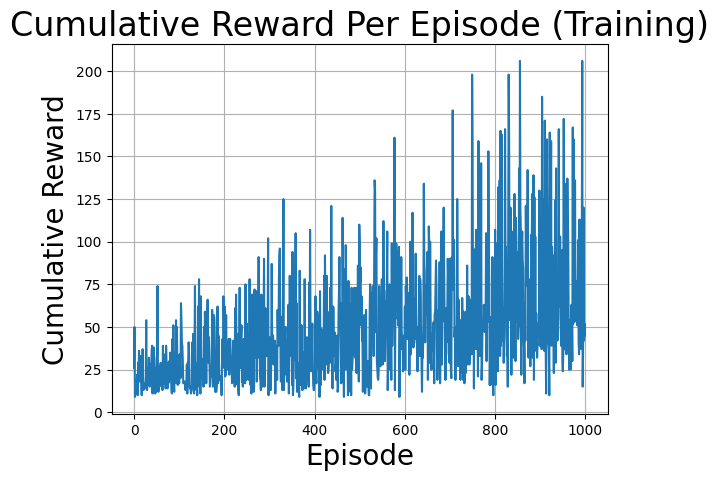

In [270]:
plt.figure()
plt.plot(rewards_per_episode_cartpole_DDQN)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode (Training)', fontsize=24)
plt.grid()
plt.show()

In [192]:
n_episodes = 10  
rewards_per_episode_testing_cart_DDQN = []
env = gym.make("CartPole-v1", render_mode="rgb_array")

for e in range(n_episodes):
    current_state, info = env.reset()
    terminated = False
    total_episode_reward = 0
    total_steps = 0
    
    while not terminated: 
        total_steps += 1
        
        with torch.no_grad():
            action = online_network_cartpole_DDQN(torch.tensor(current_state, dtype=torch.float)).argmax().item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        
        total_episode_reward += reward
        
        current_state = next_state
    
    rewards_per_episode_testing_cart_DDQN.append(total_episode_reward)

/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_1303/69166130.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


Text(0, 0.5, 'Reward')

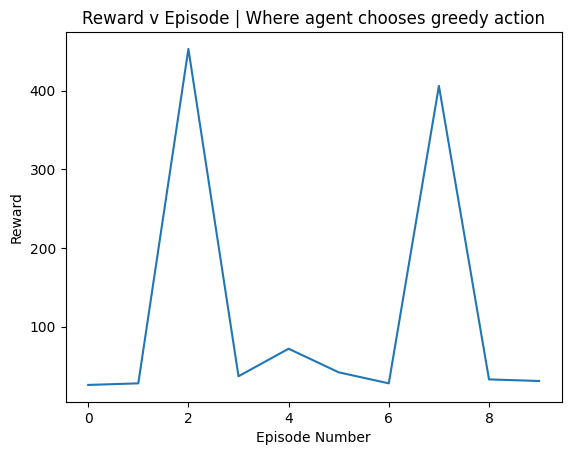

In [271]:
plt.plot(rewards_per_episode_testing_cart_DDQN)
plt.title('Reward v Episode | Where agent chooses greedy action')
plt.xlabel('Episode Number')
plt.ylabel('Reward')

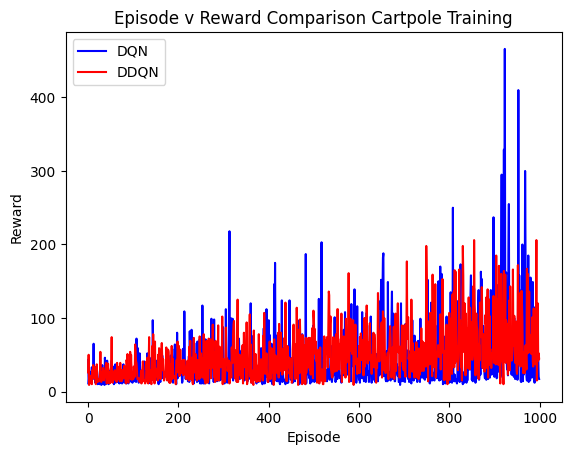

In [272]:
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode_cartpole, label="DQN", color="blue")
plt.plot(rewards_per_episode_cartpole_DDQN, label="DDQN", color="red")

plt.legend()

# Adding labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode v Reward Comparison Cartpole Training")

# Display the plot
plt.show()

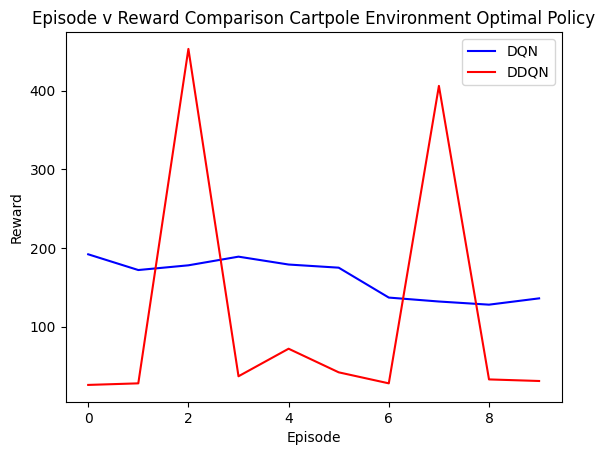

In [273]:
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode_testing_cart, label="DQN", color="blue")
plt.plot(rewards_per_episode_testing_cart_DDQN, label="DDQN", color="red")

plt.legend()

# Adding labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode v Reward Comparison Cartpole Environment Optimal Policy")

# Display the plot
plt.show()

# Applying Deep Q Networks on Cliffwalking

In [62]:
class ReplayBufferCliffWalking:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, state, action, reward, next_state, terminated, truncated):
        experience_tuple = (state, action, reward, next_state, terminated, truncated)
        self.memory.append(experience_tuple)    
    def __len__(self):
        return len(self.memory)
    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, terminated, truncated = (zip(*batch))
        states_tensor = torch.tensor(states, dtype=torch.float32)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32)
        terminated_tensor = torch.tensor(terminated, dtype=torch.long)
        truncated_tensor = torch.tensor(truncated, dtype=torch.long)
        actions_tensor = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, terminated_tensor, truncated_tensor

In [98]:
class QNetworkCliffWalking(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetworkCliffWalking, self).__init__()
        self.fc1 = nn.Linear(state_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 70)
        self.fc4 = nn.Linear(70, action_size)
    def forward(self, state):
#         print("INSTATE", state)
        x = F.leaky_relu(self.fc1(torch.tensor(state)), negative_slope=0.01)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.01)
        return self.fc4(x)

In [108]:
replay_buffer = ReplayBufferCliffWalking(4000)
step = 0
total_steps = 0

n_episodes =1000 
batch_size = 64  
gamma = 0.95  
lr = 0.0005  
target_update_frequency = 800 
min_exploration_proba = 0.01  
exploration_proba = 0.99  
exploration_decreasing_decay = 0.001   
epsilon_values_CliffWalking = []
rewards_per_episode_CliffWalking = []
#     exploration_proba = max(min_exploration_proba, exploration_proba * (1 - exploration_decreasing_decay))

online_network_CliffWalking = QNetworkCliffWalking(1, 4)
target_network_CliffWalking = QNetworkCliffWalking(1, 4)
target_network_CliffWalking.load_state_dict(online_network_CliffWalking.state_dict())  
optimizer = optim.Adam(online_network_CliffWalking.parameters(), lr=lr)

env = gym.make("CliffWalking-v0", render_mode="rgb_array")

for e in range(n_episodes):
    current_state, info = env.reset()
    terminated = False
    total_episode_reward = 0
    total_steps = 0
    truncated = False
    print("episode:", e, "epsilon:", exploration_proba)
    while not terminated and not truncated: 
        
        total_steps += 1
        
        # Selecting action using epsilon-greedy policy
        if np.random.rand() < exploration_proba:
            action = env.action_space.sample()  
        else:
            with torch.no_grad():
                action = online_network_CliffWalking(torch.tensor([[current_state]], dtype=torch.float)).argmax().item()
                

        # Perform the action
        next_state, reward, terminated, truncated, info = env.step(action)
        
        
        # Store experience in replay buffer
        replay_buffer.push(current_state, action, reward, next_state, terminated, truncated)
        
        # Perform learning step if replay buffer has enough samples
        if len(replay_buffer) >= batch_size:
            # Sample minibatch from the replay buffer
            states, actions, rewards, next_states, terminated_, truncated_ = replay_buffer.sample(batch_size)

            # Computing Q-values for the current states
#             print("states", states)
#             print("passing in the network", online_network_LunarLander(states.view(-1, 1)))
            q_values = online_network_CliffWalking(states.view(-1, 1)).gather(1, actions).squeeze(1)
            

            
            # Computing target Q-values for the next states
            with torch.no_grad():
                next_q_values = target_network_CliffWalking(next_states.view(-1, 1)).max(1)[0]
                target_q_values = rewards + gamma * next_q_values * (1 - terminated_)
            
            # Computing loss and perform backpropagation
            loss = nn.MSELoss()(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Hard update the target network every fixed number of steps
        if total_steps % target_update_frequency == 0:
            target_network_CliffWalking.load_state_dict(online_network_CliffWalking.state_dict())
        
        # Updating total reward for the episode
        total_episode_reward += reward
        
        # Moving to the next state
        current_state = next_state
    
    
    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay * e))
    epsilon_values_CliffWalking.append(exploration_proba)
    rewards_per_episode_CliffWalking.append(total_episode_reward)

target_network_CliffWalking.load_state_dict(online_network_CliffWalking.state_dict())

episode: 0 epsilon: 0.99


/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_1303/1447430426.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = F.leaky_relu(self.fc1(torch.tensor(state)), negative_slope=0.01)


episode: 1 epsilon: 1.0
episode: 2 epsilon: 0.999000499833375
episode: 3 epsilon: 0.9980019986673331
episode: 4 epsilon: 0.997004495503373
episode: 5 epsilon: 0.9960079893439915
episode: 6 epsilon: 0.9950124791926823
episode: 7 epsilon: 0.9940179640539353
episode: 8 epsilon: 0.9930244429332351
episode: 9 epsilon: 0.9920319148370607
episode: 10 epsilon: 0.9910403787728836
episode: 11 epsilon: 0.9900498337491681
episode: 12 epsilon: 0.9890602787753687
episode: 13 epsilon: 0.9880717128619305
episode: 14 epsilon: 0.9870841350202876
episode: 15 epsilon: 0.9860975442628619
episode: 16 epsilon: 0.9851119396030626
episode: 17 epsilon: 0.9841273200552851
episode: 18 epsilon: 0.9831436846349096
episode: 19 epsilon: 0.9821610323583008
episode: 20 epsilon: 0.981179362242806
episode: 21 epsilon: 0.9801986733067553
episode: 22 epsilon: 0.9792189645694596
episode: 23 epsilon: 0.97824023505121
episode: 24 epsilon: 0.9772624837732771
episode: 25 epsilon: 0.9762857097579093
episode: 26 epsilon: 0.975309

episode: 205 epsilon: 0.8154623711872927
episode: 206 epsilon: 0.8146473164114145
episode: 207 epsilon: 0.8138330762829207
episode: 208 epsilon: 0.813019649987571
episode: 209 epsilon: 0.812207036711939
episode: 210 epsilon: 0.8113952356434114
episode: 211 epsilon: 0.8105842459701871
episode: 212 epsilon: 0.8097740668812763
episode: 213 epsilon: 0.8089646975664998
episode: 214 epsilon: 0.8081561372164884
episode: 215 epsilon: 0.8073483850226815
episode: 216 epsilon: 0.8065414401773269
episode: 217 epsilon: 0.8057353018734796
episode: 218 epsilon: 0.8049299693050015
episode: 219 epsilon: 0.8041254416665596
episode: 220 epsilon: 0.8033217181536265
episode: 221 epsilon: 0.8025187979624785
episode: 222 epsilon: 0.8017166802901953
episode: 223 epsilon: 0.8009153643346592
episode: 224 epsilon: 0.8001148492945541
episode: 225 epsilon: 0.7993151343693651
episode: 226 epsilon: 0.7985162187593771
episode: 227 epsilon: 0.7977181016656743
episode: 228 epsilon: 0.7969207822901396
episode: 229 epsil

episode: 407 epsilon: 0.6663101674248864
episode: 408 epsilon: 0.6656441903015212
episode: 409 epsilon: 0.6649788788224019
episode: 410 epsilon: 0.6643142323222168
episode: 411 epsilon: 0.6636502501363194
episode: 412 epsilon: 0.6629869316007274
episode: 413 epsilon: 0.6623242760521222
episode: 414 epsilon: 0.6616622828278483
episode: 415 epsilon: 0.6610009512659124
episode: 416 epsilon: 0.6603402807049829
episode: 417 epsilon: 0.659680270484389
episode: 418 epsilon: 0.6590209199441207
episode: 419 epsilon: 0.6583622284248272
episode: 420 epsilon: 0.657704195267817
episode: 421 epsilon: 0.6570468198150567
episode: 422 epsilon: 0.6563901014091712
episode: 423 epsilon: 0.6557340393934418
episode: 424 epsilon: 0.6550786331118063
episode: 425 epsilon: 0.6544238819088586
episode: 426 epsilon: 0.6537697851298473
episode: 427 epsilon: 0.6531163421206756
episode: 428 epsilon: 0.6524635522279004
episode: 429 epsilon: 0.651811414798732
episode: 430 epsilon: 0.6511599291810325
episode: 431 epsilo

episode: 611 epsilon: 0.5433508690744998
episode: 612 epsilon: 0.542807789790324
episode: 613 epsilon: 0.5422652533139832
episode: 614 epsilon: 0.541723259102941
episode: 615 epsilon: 0.5411818066152029
episode: 616 epsilon: 0.5406408953093166
episode: 617 epsilon: 0.5401005246443706
episode: 618 epsilon: 0.5395606940799943
episode: 619 epsilon: 0.539021403076357
episode: 620 epsilon: 0.5384826510941678
episode: 621 epsilon: 0.5379444375946745
episode: 622 epsilon: 0.5374067620396636
episode: 623 epsilon: 0.5368696238914595
episode: 624 epsilon: 0.5363330226129241
episode: 625 epsilon: 0.535796957667456
episode: 626 epsilon: 0.5352614285189903
episode: 627 epsilon: 0.5347264346319975
episode: 628 epsilon: 0.5341919754714841
episode: 629 epsilon: 0.5336580505029906
episode: 630 epsilon: 0.5331246591925921
episode: 631 epsilon: 0.5325918010068972
episode: 632 epsilon: 0.5320594754130477
episode: 633 epsilon: 0.5315276818787179
episode: 634 epsilon: 0.5309964198721143
episode: 635 epsilon

episode: 811 epsilon: 0.4448580662229411
episode: 812 epsilon: 0.4444134305116268
episode: 813 epsilon: 0.44396923921378006
episode: 814 epsilon: 0.4435254918852095
episode: 815 epsilon: 0.44308218808216776
episode: 816 epsilon: 0.4426393273613511
episode: 817 epsilon: 0.44219690927989863
episode: 818 epsilon: 0.4417549333953923
episode: 819 epsilon: 0.44131339926585617
episode: 820 epsilon: 0.4408723064497561
episode: 821 epsilon: 0.44043165450599925
episode: 822 epsilon: 0.43999144299393356
episode: 823 epsilon: 0.43955167147334756
episode: 824 epsilon: 0.43911233950446965
episode: 825 epsilon: 0.4386734466479678
episode: 826 epsilon: 0.4382349924649492
episode: 827 epsilon: 0.4377969765169596
episode: 828 epsilon: 0.437359398365983
episode: 829 epsilon: 0.43692225757444114
episode: 830 epsilon: 0.4364855537051933
episode: 831 epsilon: 0.43604928632153556
episode: 832 epsilon: 0.43561345498720044
episode: 833 epsilon: 0.43517805926635666
episode: 834 epsilon: 0.43474309872360845
epis

<All keys matched successfully>

In [274]:
import pickle
online_weights = online_network_CliffWalking.state_dict()
target_weights = target_network_CliffWalking.state_dict()


with open('online_network_weights_CliffWalking.pkl', 'wb') as file:
    pickle.dump(online_weights, file)
    
with open('target_network_weights_CliffWalking.pkl', 'wb') as file:
    pickle.dump(target_weights, file)

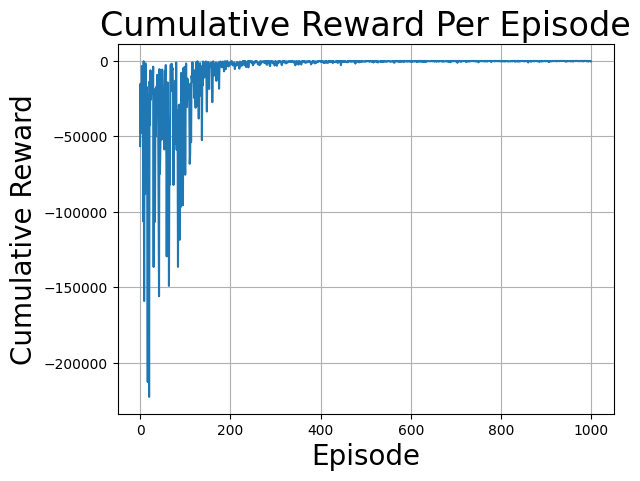

In [110]:
plt.figure()
plt.plot(rewards_per_episode_CliffWalking)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode', fontsize=24)
plt.grid()
plt.show()

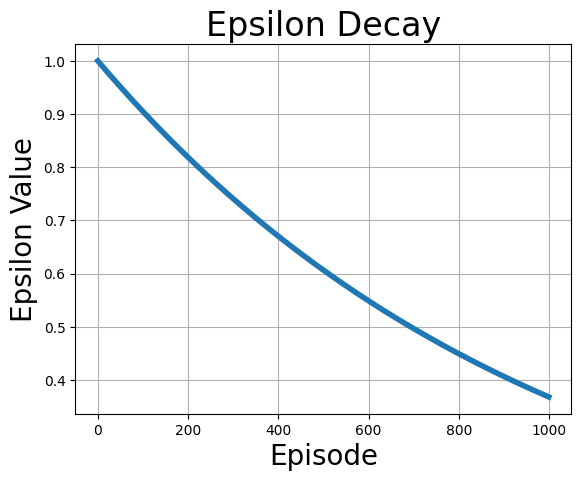

In [111]:
# Epsilon-decay graph
plt.figure()
plt.plot(epsilon_values_CliffWalking, linewidth=4)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Epsilon Value', fontsize=20)
plt.title('Epsilon Decay', fontsize=24)
plt.grid()
plt.show()

# Running optimal policy on CliffWalking

In [130]:
rewards_per_episode_testing_CliffWalking = []
n_episodes = 10
for e in range(n_episodes):
#     print(e)
    current_state, info = env.reset()
    terminated = False
    total_episode_reward = 0
    total_steps = 0
    truncated = False
#     print(e, total_steps)
    while not terminated and not truncated:
        total_steps += 1
        
        with torch.no_grad():
            action = online_network_CliffWalking(torch.tensor([[current_state]], dtype=torch.float)).argmax().item()
#             print(action, current_state) 
        next_state, reward, terminated, truncated, _ = env.step(action)
#         print(current_state, action)
        total_episode_reward += reward
        
        current_state = next_state
    
    rewards_per_episode_testing_CliffWalking.append(total_episode_reward)

/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_1303/1447430426.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = F.leaky_relu(self.fc1(torch.tensor(state)), negative_slope=0.01)


Text(0, 0.5, 'Reward')

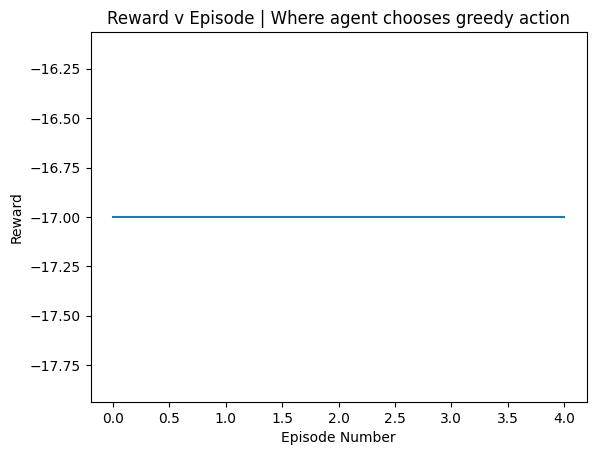

In [127]:
plt.plot(rewards_per_episode_testing_CliffWalking)
plt.title('Reward v Episode | Where agent chooses greedy action')
plt.xlabel('Episode Number')
plt.ylabel('Reward')

## Applying DDQN on CliffWalking

In [216]:
# 500
replay_buffer = ReplayBufferCliffWalking(1000)
step = 0
total_steps = 0

n_episodes = 1000 
batch_size = 64  
gamma = 0.95  
lr = 0.001  
target_update_frequency = 800 
min_exploration_proba = 0.01  
exploration_proba = 0.99  
exploration_decreasing_decay = 0.001  
epsilon_values_CliffWalking_DDQN = []
rewards_per_episode_CliffWalking_DDQN = []

online_network_CliffWalking_DDQN = QNetworkCliffWalking(1, 4)
target_network_CliffWalking_DDQN = QNetworkCliffWalking(1, 4)
target_network_CliffWalking_DDQN.load_state_dict(online_network_CliffWalking_DDQN.state_dict())  
optimizer = optim.Adam(online_network_CliffWalking_DDQN.parameters(), lr=lr)

env = gym.make("CliffWalking-v0", render_mode="rgb_array")
total_steps = 0
for e in range(n_episodes):
    current_state, info = env.reset()
    terminated = False
    total_episode_reward = 0
    truncated = False
    print("episode:", e, "Total steps:", total_steps, "epsilon:", exploration_proba)
    while not terminated and not truncated: 
        total_steps += 1
        
        # Selecting action using epsilon-greedy policy
        if np.random.rand() < exploration_proba:
            action = env.action_space.sample()  
        else:
            with torch.no_grad():
                action = online_network_CliffWalking_DDQN(torch.tensor([[current_state]], dtype=torch.float)).argmax().item()
                

        # Perform the action
        next_state, reward, terminated, truncated, info = env.step(action)
        
        
        # Store experience in replay buffer
        replay_buffer.push(current_state, action, reward, next_state, terminated, truncated)
        
        # Perform learning step if replay buffer has enough samples
        if len(replay_buffer) >= batch_size:
            # Sample minibatch from the replay buffer
            states, actions, rewards, next_states, terminated_, truncated_ = replay_buffer.sample(batch_size)

            # Computing Q-values for the current states
#             print("states", states)
#             print("passing in the network", online_network_LunarLander(states.view(-1, 1)))
            q_values = online_network_CliffWalking_DDQN(states.view(-1, 1)).gather(1, actions).squeeze(1)
            

            
            # Computing target Q-values for the next states
            with torch.no_grad():

                next_actions = online_network_CliffWalking_DDQN(next_states.view(-1, 1)).argmax(1)
                # Target network evaluates the Q-values of these actions
                next_q_values = target_network_CliffWalking_DDQN(next_states.view(-1, 1)).gather(1, next_actions.unsqueeze(1)).squeeze(1)
                target_q_values = rewards + gamma * next_q_values * (1 - terminated_)
            


            
            # Computing loss and perform backpropagation
            loss = nn.MSELoss()(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Hard update the target network every fixed number of steps
        if total_steps % target_update_frequency == 0:
            target_network_CliffWalking_DDQN.load_state_dict(online_network_CliffWalking_DDQN.state_dict())
        
        # Updating total reward for the episode
        total_episode_reward += reward
        
        # Moving to the next state
        current_state = next_state
    
    
    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay * e))
    epsilon_values_CliffWalking_DDQN.append(exploration_proba)
    rewards_per_episode_CliffWalking_DDQN.append(total_episode_reward)


episode: 0 Total steps: 0 epsilon: 0.99


/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_1303/1447430426.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = F.leaky_relu(self.fc1(torch.tensor(state)), negative_slope=0.01)


episode: 1 Total steps: 3133 epsilon: 1.0
episode: 2 Total steps: 7346 epsilon: 0.999000499833375
episode: 3 Total steps: 7539 epsilon: 0.9980019986673331
episode: 4 Total steps: 13244 epsilon: 0.997004495503373
episode: 5 Total steps: 27122 epsilon: 0.9960079893439915
episode: 6 Total steps: 28394 epsilon: 0.9950124791926823
episode: 7 Total steps: 35255 epsilon: 0.9940179640539353
episode: 8 Total steps: 39046 epsilon: 0.9930244429332351
episode: 9 Total steps: 39507 epsilon: 0.9920319148370607
episode: 10 Total steps: 53795 epsilon: 0.9910403787728836
episode: 11 Total steps: 55704 epsilon: 0.9900498337491681
episode: 12 Total steps: 59602 epsilon: 0.9890602787753687
episode: 13 Total steps: 61874 epsilon: 0.9880717128619305
episode: 14 Total steps: 69208 epsilon: 0.9870841350202876
episode: 15 Total steps: 75234 epsilon: 0.9860975442628619
episode: 16 Total steps: 84904 epsilon: 0.9851119396030626
episode: 17 Total steps: 91154 epsilon: 0.9841273200552851
episode: 18 Total steps: 9

episode: 138 Total steps: 529148 epsilon: 0.8719702261321094
episode: 139 Total steps: 534851 epsilon: 0.8710986917457983
episode: 140 Total steps: 535459 epsilon: 0.8702280284582515
episode: 141 Total steps: 544271 epsilon: 0.8693582353988059
episode: 142 Total steps: 545633 epsilon: 0.8684893116976679
episode: 143 Total steps: 548052 epsilon: 0.867621256485914
episode: 144 Total steps: 556748 epsilon: 0.8667540688954889
episode: 145 Total steps: 557495 epsilon: 0.865887748059205
episode: 146 Total steps: 560118 epsilon: 0.8650222931107413
episode: 147 Total steps: 567102 epsilon: 0.8641577031846428
episode: 148 Total steps: 568407 epsilon: 0.8632939774163194
episode: 149 Total steps: 568815 epsilon: 0.8624311149420455
episode: 150 Total steps: 569173 epsilon: 0.8615691148989583
episode: 151 Total steps: 569430 epsilon: 0.8607079764250578
episode: 152 Total steps: 570045 epsilon: 0.8598476986592055
episode: 153 Total steps: 570375 epsilon: 0.8589882807411234
episode: 154 Total steps: 

episode: 273 Total steps: 717993 epsilon: 0.7618542610898376
episode: 274 Total steps: 718198 epsilon: 0.7610927876289343
episode: 275 Total steps: 718259 epsilon: 0.7603320752608821
episode: 276 Total steps: 718316 epsilon: 0.7595721232249685
episode: 277 Total steps: 718823 epsilon: 0.7588129307612413
episode: 278 Total steps: 719213 epsilon: 0.7580544971105083
episode: 279 Total steps: 720195 epsilon: 0.7572968215143355
episode: 280 Total steps: 720330 epsilon: 0.7565399032150474
episode: 281 Total steps: 720745 epsilon: 0.7557837414557255
episode: 282 Total steps: 721385 epsilon: 0.755028335480208
episode: 283 Total steps: 721527 epsilon: 0.754273684533089
episode: 284 Total steps: 721578 epsilon: 0.7535197878597172
episode: 285 Total steps: 722099 epsilon: 0.7527666447061963
episode: 286 Total steps: 722185 epsilon: 0.7520142543193826
episode: 287 Total steps: 722520 epsilon: 0.751262615946886
episode: 288 Total steps: 722593 epsilon: 0.750511728837068
episode: 289 Total steps: 72

episode: 408 Total steps: 764157 epsilon: 0.6656441903015212
episode: 409 Total steps: 764594 epsilon: 0.6649788788224019
episode: 410 Total steps: 764709 epsilon: 0.6643142323222168
episode: 411 Total steps: 764789 epsilon: 0.6636502501363194
episode: 412 Total steps: 764958 epsilon: 0.6629869316007274
episode: 413 Total steps: 765164 epsilon: 0.6623242760521222
episode: 414 Total steps: 765600 epsilon: 0.6616622828278483
episode: 415 Total steps: 765688 epsilon: 0.6610009512659124
episode: 416 Total steps: 765741 epsilon: 0.6603402807049829
episode: 417 Total steps: 765854 epsilon: 0.659680270484389
episode: 418 Total steps: 765897 epsilon: 0.6590209199441207
episode: 419 Total steps: 766098 epsilon: 0.6583622284248272
episode: 420 Total steps: 766134 epsilon: 0.657704195267817
episode: 421 Total steps: 766198 epsilon: 0.6570468198150567
episode: 422 Total steps: 766293 epsilon: 0.6563901014091712
episode: 423 Total steps: 766394 epsilon: 0.6557340393934418
episode: 424 Total steps: 

episode: 546 Total steps: 789542 epsilon: 0.5798417833398464
episode: 547 Total steps: 789624 epsilon: 0.579262231380782
episode: 548 Total steps: 789681 epsilon: 0.5786832586839974
episode: 549 Total steps: 789787 epsilon: 0.5781048646705196
episode: 550 Total steps: 790016 epsilon: 0.5775270487619547
episode: 551 Total steps: 790071 epsilon: 0.5769498103804866
episode: 552 Total steps: 790175 epsilon: 0.5763731489488771
episode: 553 Total steps: 790309 epsilon: 0.5757970638904645
episode: 554 Total steps: 790429 epsilon: 0.5752215546291638
episode: 555 Total steps: 790468 epsilon: 0.5746466205894657
episode: 556 Total steps: 790516 epsilon: 0.574072261196436
episode: 557 Total steps: 790636 epsilon: 0.5734984758757153
episode: 558 Total steps: 790700 epsilon: 0.5729252640535184
episode: 559 Total steps: 790747 epsilon: 0.5723526251566332
episode: 560 Total steps: 790913 epsilon: 0.5717805586124209
episode: 561 Total steps: 790938 epsilon: 0.5712090638488149
episode: 562 Total steps: 

episode: 685 Total steps: 834926 epsilon: 0.5045945719335512
episode: 686 Total steps: 835025 epsilon: 0.5040902295748255
episode: 687 Total steps: 835230 epsilon: 0.5035863913063714
episode: 688 Total steps: 835379 epsilon: 0.5030830566243506
episode: 689 Total steps: 835681 epsilon: 0.5025802250254283
episode: 690 Total steps: 835719 epsilon: 0.502077896006773
episode: 691 Total steps: 835820 epsilon: 0.5015760690660555
episode: 692 Total steps: 835879 epsilon: 0.5010747437014489
episode: 693 Total steps: 835913 epsilon: 0.5005739194116277
episode: 694 Total steps: 835972 epsilon: 0.5000735956957676
episode: 695 Total steps: 836580 epsilon: 0.4995737720535449
episode: 696 Total steps: 837450 epsilon: 0.49907444798513595
episode: 697 Total steps: 844362 epsilon: 0.4985756229912165
episode: 698 Total steps: 844618 epsilon: 0.4980772965729616
episode: 699 Total steps: 846249 epsilon: 0.4975794682320448
episode: 700 Total steps: 851211 epsilon: 0.4970821374706377
episode: 701 Total steps

episode: 821 Total steps: 912487 epsilon: 0.44043165450599925
episode: 822 Total steps: 912565 epsilon: 0.43999144299393356
episode: 823 Total steps: 912603 epsilon: 0.43955167147334756
episode: 824 Total steps: 912710 epsilon: 0.43911233950446965
episode: 825 Total steps: 912743 epsilon: 0.4386734466479678
episode: 826 Total steps: 912842 epsilon: 0.4382349924649492
episode: 827 Total steps: 912860 epsilon: 0.4377969765169596
episode: 828 Total steps: 912890 epsilon: 0.437359398365983
episode: 829 Total steps: 912910 epsilon: 0.43692225757444114
episode: 830 Total steps: 912970 epsilon: 0.4364855537051933
episode: 831 Total steps: 912985 epsilon: 0.43604928632153556
episode: 832 Total steps: 913015 epsilon: 0.43561345498720044
episode: 833 Total steps: 913036 epsilon: 0.43517805926635666
episode: 834 Total steps: 913069 epsilon: 0.43474309872360845
episode: 835 Total steps: 913094 epsilon: 0.4343085729239951
episode: 836 Total steps: 913136 epsilon: 0.4338744814329909
episode: 837 Tot

episode: 963 Total steps: 917980 epsilon: 0.38212786547866506
episode: 964 Total steps: 918005 epsilon: 0.3817459286134471
episode: 965 Total steps: 918026 epsilon: 0.38136437349418956
episode: 966 Total steps: 918047 epsilon: 0.38098319973933725
episode: 967 Total steps: 918071 epsilon: 0.38060240696771647
episode: 968 Total steps: 918090 epsilon: 0.38022199479853436
episode: 969 Total steps: 918116 epsilon: 0.3798419628513787
episode: 970 Total steps: 918142 epsilon: 0.37946231074621756
episode: 971 Total steps: 918177 epsilon: 0.37908303810339883
episode: 972 Total steps: 918206 epsilon: 0.37870414454364976
episode: 973 Total steps: 918231 epsilon: 0.3783256296880768
episode: 974 Total steps: 918275 epsilon: 0.37794749315816506
episode: 975 Total steps: 918298 epsilon: 0.37756973457577797
episode: 976 Total steps: 918321 epsilon: 0.37719235356315695
episode: 977 Total steps: 918366 epsilon: 0.37681534974292086
episode: 978 Total steps: 918396 epsilon: 0.37643872273806595
episode: 97

In [275]:
import pickle
online_weights = online_network_CliffWalking_DDQN.state_dict()
target_weights = target_network_CliffWalking_DDQN.state_dict()


with open('online_network_weights_CliffWalking_DDQN.pkl', 'wb') as file:
    pickle.dump(online_weights, file)
    
with open('target_network_weights_CliffWalking_DDQN.pkl', 'wb') as file:
    pickle.dump(target_weights, file)

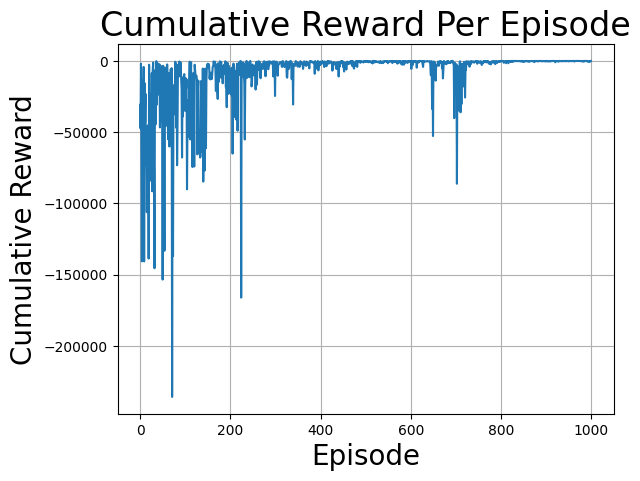

In [218]:
plt.figure()
plt.plot(rewards_per_episode_CliffWalking_DDQN)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode', fontsize=24)
plt.grid()
plt.show()

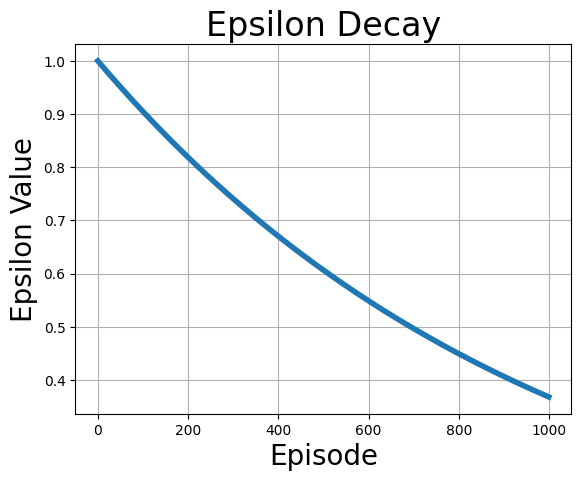

In [219]:
# Epsilon-decay graph
plt.figure()
plt.plot(epsilon_values_CliffWalking_DDQN, linewidth=4)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Epsilon Value', fontsize=20)
plt.title('Epsilon Decay', fontsize=24)
plt.grid()
plt.show()

## Running optimal policy on cliff walking 

In [220]:
rewards_per_episode_testing_CliffWalking_DDQN = []

n_episodes = 10
for e in range(n_episodes):
    current_state, info = env.reset()
    terminated = False
    total_episode_reward = 0
    total_steps = 0
    truncated = False
#     print(e, total_steps)
    while not terminated and not truncated: 
        total_steps += 1
        
        with torch.no_grad():
            action = online_network_CliffWalking_DDQN(torch.tensor([[current_state]], dtype=torch.float)).argmax().item()
#             print(action, current_state) 
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        total_episode_reward += reward
        
        current_state = next_state
    
    rewards_per_episode_testing_CliffWalking_DDQN.append(total_episode_reward)

/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_1303/1447430426.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = F.leaky_relu(self.fc1(torch.tensor(state)), negative_slope=0.01)


Text(0, 0.5, 'Reward')

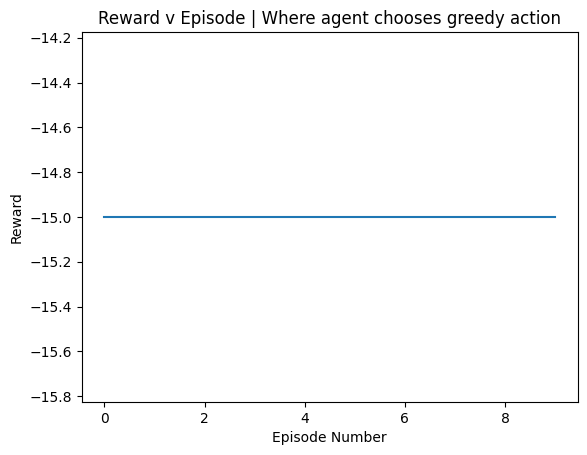

In [221]:
plt.plot(rewards_per_episode_testing_CliffWalking_DDQN)
plt.title('Reward v Episode | Where agent chooses greedy action')
plt.xlabel('Episode Number')
plt.ylabel('Reward')

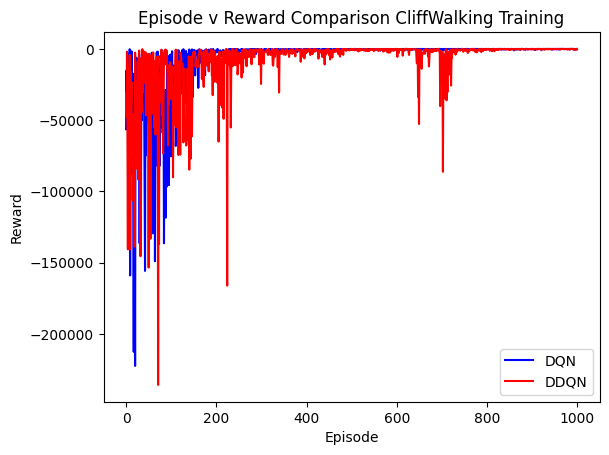

In [276]:
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode_CliffWalking, label="DQN", color="blue")
plt.plot(rewards_per_episode_CliffWalking_DDQN, label="DDQN", color="red")

plt.legend()

# Adding labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode v Reward Comparison CliffWalking Training")

# Display the plot
plt.show()

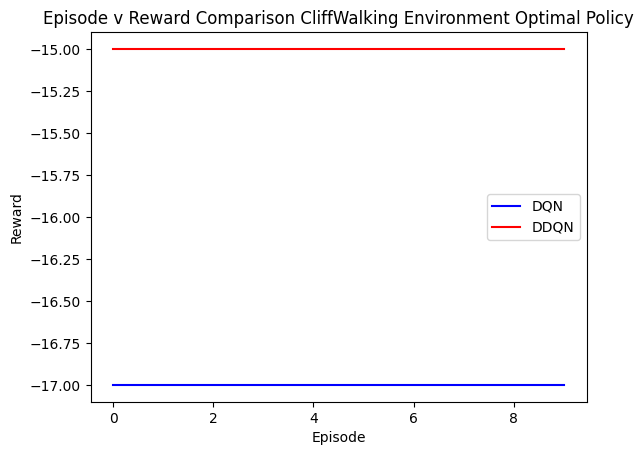

In [266]:
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode_testing_CliffWalking, label="DQN", color="blue")
plt.plot(rewards_per_episode_testing_CliffWalking_DDQN, label="DDQN", color="red")

plt.legend()

# Adding labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode v Reward Comparison CliffWalking Environment Optimal Policy")

# Display the plot
plt.show()